<h1>День 3. Отклик.</h1>

<h3>Сервисный модуль</h3>
<b><i>Пожалуйста, запустите следующие несколько ячеек при первом запуске ноутбука!</i></b>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%pip install -r '/home/jupyter/work/resources/a2nced/requirements.txt'

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 427 kB 2.6 MB/s            
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import os
import sys
from pathlib import Path
dir_path = Path(os.getcwd()).resolve().parent.as_posix()
sys.path.append(dir_path)

<h3>Конец сервисного модуля</h3>

<br>
<h1>Практика 1</h1>
<h3>Построение базовой модели отклика</h3>

<h1>Подготовка данных</h1>
<h3>Загрузка данных</h3>

In [4]:
# необходимые импорты
import pandas as pd
import numpy as np
import datetime as dt

In [5]:
# найдем директорию, в которой хранятся наши данные
_PATH = '/home/jupyter/mnt/s3/course-test/day_3/'

In [6]:
transactions_path   = os.path.join(_PATH, 'day_3_transactions.csv') # транзакции
demographics_path   = os.path.join(_PATH, 'day_3_demogr.csv') # информация о клиентах
prod_path           = os.path.join(_PATH, 'day_3_product.csv') # информация о товарах
orders_path         = os.path.join(_PATH, 'day_3_orders.csv') # информация о заказах, сгруппированная по корзинам
campaign_desc_path  = os.path.join(_PATH, 'day_3_campaign_desc.csv') # информация о периодах проведения РК
campaign_table_path = os.path.join(_PATH, 'day_3_campaign_table.csv') # информация о фактах коммуникации с клиентами в рамках РК
coupon_path         = os.path.join(_PATH, 'day_3_coupon.csv') # информация о продуктах, входящих в состав купонов
coupon_red_path     = os.path.join(_PATH, 'day_3_coupon_redempt.csv')

In [7]:
transactions_df = pd.read_csv(transactions_path)
transactions_df['purch_date_time'] = transactions_df['purch_date_time'].astype(np.datetime64)

In [8]:
demographics_df = pd.read_csv(demographics_path)

In [9]:
prod_df = pd.read_csv(prod_path)

In [10]:
orders_df = pd.read_csv(orders_path)
orders_df['purch_date_time'] = orders_df['purch_date_time'].astype(np.datetime64)

In [11]:
# данные о РК, которые мы не использовали ранее
campaign_desc_df = pd.read_csv(campaign_desc_path)
campaign_desc_df['start_day'] = campaign_desc_df['start_day'].astype(np.datetime64)
campaign_desc_df['end_day'] = campaign_desc_df['end_day'].astype(np.datetime64)
campaign_desc_df.head()

description  campaign  start_day    end_day
0       TypeB        24 2020-05-19 2020-07-18
1       TypeC        15 2020-01-28 2020-07-07
2       TypeB        25 2020-05-19 2020-06-20
3       TypeC        20 2020-04-05 2020-06-14
4       TypeB        23 2020-05-06 2020-06-13

In [12]:
campaign_table_df = pd.read_csv(campaign_table_path)
campaign_table_df.head()

description  user_id  campaign
0       TypeA       17        26
1       TypeA       27        26
2       TypeA      212        26
3       TypeA      208        26
4       TypeA      192        26

In [13]:
coupon_df = pd.read_csv(coupon_path)
coupon_df.head()

coupon_upc  product_id  campaign
0  10000089061       27160         4
1  10000089064       27754         9
2  10000089073       28897        12
3  51800009050       28919        28
4  52100000076       28929        25

In [14]:
coupon_red_df = pd.read_csv(coupon_red_path)
coupon_red_df['day'] = coupon_red_df['day'].astype(np.datetime64)
coupon_red_df.head()

user_id        day   coupon_upc  campaign
0        1 2019-09-24  10000085364         8
1        1 2019-09-24  51700010076         8
2        1 2019-09-30  54200000033         8
3        1 2020-03-18  10000085476        18
4        1 2020-03-18  54200029176        18

<h4>Сбор обучающей выборки</h4>

In [15]:
# отфильтруем их и положим резльтат в переменную
available_ids = demographics_df['user_id'].values

In [16]:
coupon_merged = campaign_table_df.merge(coupon_df.drop('product_id', axis=1), on='campaign')

In [17]:
used_coupons = coupon_red_df[['user_id', 'coupon_upc', 'campaign']].drop_duplicates()

In [18]:
used_coupons['used'] = 1

In [19]:
used_coupons.head()

user_id   coupon_upc  campaign  used
0        1  10000085364         8     1
1        1  51700010076         8     1
2        1  54200000033         8     1
3        1  10000085476        18     1
4        1  54200029176        18     1

In [20]:
coupon_and_prod = coupon_df.merge(prod_df, how='left', on='product_id')
coupon_and_prod.head()

coupon_upc  product_id  campaign  manufacturer department     brand  \
0  10000089061       27160         4            69    GROCERY   Private   
1  10000089064       27754         9            69    GROCERY   Private   
2  10000089073       28897        12            69    GROCERY   Private   
3  51800009050       28919        28           236    GROCERY  National   
4  52100000076       28929        25           317    GROCERY  National   

             commodity_desc              sub_commodity_desc  \
0            SHORTENING/OIL             VEGETABLE/SALAD OIL   
1    FRZN VEGETABLE/VEG DSH  FRZN BAGGED VEGETABLES - PLAIN   
2                      EGGS                  EGGS - X-LARGE   
3  REFRGRATD DOUGH PRODUCTS       REFRIGERATED COOKIES-CHUB   
4                    CHEESE                   STRING CHEESE   

  curr_size_of_product  
0                48 OZ  
1                16 OZ  
2           A D   1 DZ  
3              16.5 OZ  
4           AB    8 OZ

In [21]:
# начнем формировать выборку для обучения
df = demographics_df[['user_id', 'age_desc', 'income_desc', 'no_kids']] # базовый набор характеристик

In [22]:
# Нужно обогатить витрину данными о предыдущих кампаниях
# наши уникальные айдишники:
ads_participants = campaign_table_df['user_id'].unique()
ads_participants.sort()
ads_participants.shape

(1584,)

In [23]:
available_users = df['user_id'].values

In [24]:
camp_mask = ((campaign_table_df['user_id'].isin(df['user_id'])) &\
             (campaign_table_df['campaign'] == 8))

In [25]:
campaign_table_df.loc[camp_mask]['user_id'].unique().shape

(579,)

In [26]:
# клиенты, которым было направлено рекламное предложение хотя бы в рамках одной кампании
ads_with_users = pd.DataFrame()
ads_with_users['user_id'] = campaign_table_df.loc[camp_mask]['user_id'].unique()
ads_with_users['communication'] = 1

In [27]:
due_day = campaign_desc_df[campaign_desc_df.campaign==8]['start_day']
due_day_2 = campaign_desc_df[campaign_desc_df.campaign==8]['start_day'] - dt.timedelta(days=180)

In [28]:
# добавим новый признак
prev_campaigns = campaign_desc_df.loc[(campaign_desc_df['start_day'] < due_day.values[0]) &\
                                      (campaign_desc_df['start_day'] > due_day_2.values[0]) &\
                                      (campaign_desc_df['campaign'] != 8)]['campaign'].values

In [29]:
prev_users_ = campaign_table_df.loc[campaign_table_df['campaign'].isin(prev_campaigns)]['user_id'].unique()

In [30]:
prev_users = pd.DataFrame()
prev_users['user_id'] = prev_users_
prev_users['prev_communication'] = 1

In [31]:
df = df.merge(prev_users, how='left', on='user_id')
df.head()

user_id age_desc income_desc  no_kids  prev_communication
0        1      65+      35-49K     True                 1.0
1        7    45-54      50-74K     True                 NaN
2        8    25-34      25-34K    False                 1.0
3       13    25-34      75-99K    False                 1.0
4       16    45-54      50-74K     True                 1.0

<b>Задача:</b> <b><i>Предсказание отклика клиента на коммуникацию в рамках кампании.</i></b>

Новый подход к обучению и тестированию - на трех последовательных похожих по параметрам и охвату рекламных кампаниях:
- обучние модели на компании # 8;
- оот на кампании # 13;
- скоринг на кампании # 18.

In [32]:
campaign_desc_df[campaign_desc_df.campaign.isin([8, 13, 18])]

description  campaign  start_day    end_day
7        TypeA        18 2020-03-08 2020-05-02
12       TypeA        13 2019-12-16 2020-02-01
17       TypeA         8 2019-09-15 2019-11-02

In [33]:
# выберем даты, соответствующие нашим окнам для сбора агрегатов
cut_date = '2019-09-14'

In [34]:
# используем функцию, которую мы написали для первого дня
from utils.data_prep import get_feature_matrix

feature_matrix = get_feature_matrix(orders_df=orders_df,
                                    date=cut_date,
                                    demogr_df=demographics_df)

In [35]:
feature_matrix.head()

user_id age_desc income_desc  no_kids  quantity_min_14_days  \
0        1      65+      35-49K     True                   1.0   
1        7    45-54      50-74K     True                   NaN   
2        8    25-34      25-34K    False                   NaN   
3       13    25-34      75-99K    False                   8.0   
4       16    45-54      50-74K     True                   1.0   

   quantity_max_14_days  quantity_mean_14_days  quantity_median_14_days  \
0                  46.0                   23.5                     23.5   
1                   NaN                    NaN                      NaN   
2                   NaN                    NaN                      NaN   
3               17266.0                 9612.0                  14496.0   
4                9598.0                 1922.8                      5.0   

   quantity_std_14_days  quantity_sum_14_days  ...  default_price_max_60_days  \
0             31.819805                  47.0  ...                     120.69   
1                   NaN                   NaN  ...                     139.18   
2                   NaN                   NaN  ...                     164.00   
3           8804.842191               48060.0  ...                     124.71   
4           4290.567818                9614.0  ...                      35.95   

   default_price_mean_60_days  default_price_median_60_days  \
0                   53.422500                        41.525   
1                   72.208000                        91.760   
2                   68.900000                        42.260   
3                   51.594400                        46.000   
4                   13.564375                         9.570   

   default_price_std_60_days  default_price_sum_60_days  \
0                  55.873426                     427.38   
1                  52.856793                     361.04   
2                  54.751945                     757.90   
3                  33.037212                    1289.86   
4                  10.590970                     217.03   

   default_price_vals_range_60_days  default_price_quantile_25_60_days  \
0                            120.69                             1.3900   
1                            131.79                            30.7700   
2                            153.15                            33.2900   
3                            121.82                            32.0400   
4                             32.57                             5.8975   

   default_price_quantile_75_60_days  \
0                           108.5850   
1                            91.9400   
2                           109.7750   
3                            71.6000   
4                            17.2375   

   default_price_interquantile_range_60_days  default_price_skewness_60_days  
0                                    107.195                        0.176591  
1                                     61.170                       -0.078820  
2                                     76.485                        0.793105  
3                                     39.560                        0.651746  
4                                     11.340                        1.186449  

[5 rows x 136 columns]

In [36]:
# Информация об отклике на предыдущие кампании
prev_response = pd.DataFrame()
prev_response['user_id'] = coupon_red_df.loc[(coupon_red_df['campaign'].isin(prev_campaigns)) &\
                                           (coupon_red_df['user_id'].isin(available_users))]['user_id']
prev_response['prev_response'] = 1
prev_response.drop_duplicates(inplace=True, ignore_index=True)

In [37]:
prev_users.head()

user_id  prev_communication
0       14                   1
1       17                   1
2       27                   1
3       51                   1
4      210                   1

In [38]:
feature_matrix = feature_matrix.merge(prev_users, how='left', on='user_id')
feature_matrix = feature_matrix.merge(prev_response, how='left', on='user_id')
feature_matrix['prev_communication'] = feature_matrix['prev_communication'].fillna(0).astype('int8')
feature_matrix['prev_response'] = feature_matrix['prev_response'].fillna(0).astype('int8')
feature_matrix.head()

user_id age_desc income_desc  no_kids  quantity_min_14_days  \
0        1      65+      35-49K     True                   1.0   
1        7    45-54      50-74K     True                   NaN   
2        8    25-34      25-34K    False                   NaN   
3       13    25-34      75-99K    False                   8.0   
4       16    45-54      50-74K     True                   1.0   

   quantity_max_14_days  quantity_mean_14_days  quantity_median_14_days  \
0                  46.0                   23.5                     23.5   
1                   NaN                    NaN                      NaN   
2                   NaN                    NaN                      NaN   
3               17266.0                 9612.0                  14496.0   
4                9598.0                 1922.8                      5.0   

   quantity_std_14_days  quantity_sum_14_days  ...  \
0             31.819805                  47.0  ...   
1                   NaN                   NaN  ...   
2                   NaN                   NaN  ...   
3           8804.842191               48060.0  ...   
4           4290.567818                9614.0  ...   

   default_price_median_60_days  default_price_std_60_days  \
0                        41.525                  55.873426   
1                        91.760                  52.856793   
2                        42.260                  54.751945   
3                        46.000                  33.037212   
4                         9.570                  10.590970   

   default_price_sum_60_days  default_price_vals_range_60_days  \
0                     427.38                            120.69   
1                     361.04                            131.79   
2                     757.90                            153.15   
3                    1289.86                            121.82   
4                     217.03                             32.57   

   default_price_quantile_25_60_days  default_price_quantile_75_60_days  \
0                             1.3900                           108.5850   
1                            30.7700                            91.9400   
2                            33.2900                           109.7750   
3                            32.0400                            71.6000   
4                             5.8975                            17.2375   

   default_price_interquantile_range_60_days  default_price_skewness_60_days  \
0                                    107.195                        0.176591   
1                                     61.170                       -0.078820   
2                                     76.485                        0.793105   
3                                     39.560                        0.651746   
4                                     11.340                        1.186449   

   prev_communication  prev_response  
0                   1              0  
1                   0              0  
2                   1              0  
3                   1              1  
4                   1              0  

[5 rows x 138 columns]

<h4>Разметка целевого события</h4>

In [39]:
# напишем функцию, которая определяет откликнувшихся на текущую кампанию
def is_target(user_id, target_list):
    if user_id in target_list:
        return(1)
    else:
        return(0)

In [40]:
feature_matrix['y'] = feature_matrix['user_id'].apply(lambda x: is_target(x,
                                                  coupon_red_df.loc[coupon_red_df['campaign'] == 8]\
                                                  ['user_id'].unique()))

In [41]:
feature_matrix.head()

user_id age_desc income_desc  no_kids  quantity_min_14_days  \
0        1      65+      35-49K     True                   1.0   
1        7    45-54      50-74K     True                   NaN   
2        8    25-34      25-34K    False                   NaN   
3       13    25-34      75-99K    False                   8.0   
4       16    45-54      50-74K     True                   1.0   

   quantity_max_14_days  quantity_mean_14_days  quantity_median_14_days  \
0                  46.0                   23.5                     23.5   
1                   NaN                    NaN                      NaN   
2                   NaN                    NaN                      NaN   
3               17266.0                 9612.0                  14496.0   
4                9598.0                 1922.8                      5.0   

   quantity_std_14_days  quantity_sum_14_days  ...  default_price_std_60_days  \
0             31.819805                  47.0  ...                  55.873426   
1                   NaN                   NaN  ...                  52.856793   
2                   NaN                   NaN  ...                  54.751945   
3           8804.842191               48060.0  ...                  33.037212   
4           4290.567818                9614.0  ...                  10.590970   

   default_price_sum_60_days  default_price_vals_range_60_days  \
0                     427.38                            120.69   
1                     361.04                            131.79   
2                     757.90                            153.15   
3                    1289.86                            121.82   
4                     217.03                             32.57   

   default_price_quantile_25_60_days  default_price_quantile_75_60_days  \
0                             1.3900                           108.5850   
1                            30.7700                            91.9400   
2                            33.2900                           109.7750   
3                            32.0400                            71.6000   
4                             5.8975                            17.2375   

   default_price_interquantile_range_60_days  default_price_skewness_60_days  \
0                                    107.195                        0.176591   
1                                     61.170                       -0.078820   
2                                     76.485                        0.793105   
3                                     39.560                        0.651746   
4                                     11.340                        1.186449   

   prev_communication  prev_response  y  
0                   1              0  1  
1                   0              0  0  
2                   1              0  1  
3                   1              1  1  
4                   1              0  0  

[5 rows x 139 columns]

In [42]:
y = feature_matrix['y']
X = feature_matrix.drop(columns=['y', 'user_id'], axis=1)

In [43]:
y.value_counts()

0    684
1    117
Name: y, dtype: int64

<h4>Подбор оптимальных гиперпараметров и обучение модели</h4>

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25,random_state=42)

In [46]:
categorical_features = ['age_desc', 'income_desc', 'no_kids', 'prev_communication', 'prev_response']
numeric_features = [feature for feature in list(X.columns) if feature not in categorical_features]

In [47]:
from utils.models import create_pipeline, search_space, param_search, unpack_model_params
from lightgbm import LGBMClassifier

In [48]:
pipeline = create_pipeline(cat_features=categorical_features,
                           numer_features=numeric_features,
                           model=LGBMClassifier(objective = "binary", random_state = 42, is_unbalance=True))

In [49]:
best = param_search(pipeline, X_train, y_train, search_space)

100%|██████████| 100/100 [03:14<00:00,  1.94s/trial, best loss: -0.7195490056818181]


In [50]:
best_params = unpack_model_params(best)

In [51]:
pipeline.set_params(**best_params)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['quantity_min_14_days',
                                                   'quantity_max_14_days',
                                                   'quantity_mean_14_days',
                                                   'quantity_median_14_days',
                                                   'quantity_std_14_days',
                                                   'quantity_sum_14_days',
                                                   'quantity_vals_range_14_days',
                                                   'quantity_quantile_25_14_day...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['age_desc', 'income_desc',
                                                   'no_kids',
                                                   'prev_communication',
                                                   'prev_response'])])),
                ('classifier',
                 LGBMClassifier(is_unbalance=True,
                                learning_rate=0.002467330842607529,
                                max_depth=14, n_estimators=950, n_jobs=8,
                                num_leaves=10, objective='binary',
                                random_state=42, reg_alpha=0.3987348399974463,
                                reg_lambda=0.6753817106804684))])

In [52]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['quantity_min_14_days',
                                                   'quantity_max_14_days',
                                                   'quantity_mean_14_days',
                                                   'quantity_median_14_days',
                                                   'quantity_std_14_days',
                                                   'quantity_sum_14_days',
                                                   'quantity_vals_range_14_days',
                                                   'quantity_quantile_25_14_day...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['age_desc', 'income_desc',
                                                   'no_kids',
                                                   'prev_communication',
                                                   'prev_response'])])),
                ('classifier',
                 LGBMClassifier(is_unbalance=True,
                                learning_rate=0.002467330842607529,
                                max_depth=14, n_estimators=950, n_jobs=8,
                                num_leaves=10, objective='binary',
                                random_state=42, reg_alpha=0.3987348399974463,
                                reg_lambda=0.6753817106804684))])

In [53]:
y_pred = pipeline.predict(X_test)

In [54]:
prob_pred = pipeline.predict_proba(X_test)

In [55]:
from sklearn.metrics import accuracy_score, plot_roc_curve
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Accuracy: 0.7810945273631841


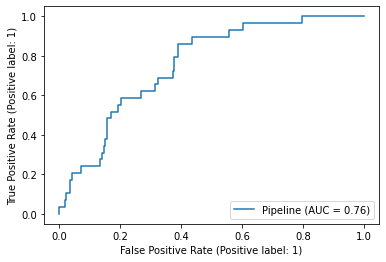

In [56]:
plot_roc_curve(pipeline, X_test, y_test)

<h4>Оценка качества модели на отложенной выборке (OOT - out of time)</h4>

In [57]:
camp_mask_oot = ((campaign_table_df['user_id'].isin(df['user_id'])) &\
             (campaign_table_df['campaign'] == 13))

In [58]:
ads_with_users_oot = pd.DataFrame()
ads_with_users_oot['user_id'] = campaign_table_df.loc[camp_mask_oot]['user_id'].unique()
ads_with_users_oot['communication'] = 1

In [59]:
due_day_oot = campaign_desc_df[campaign_desc_df.campaign==13]['start_day']
due_day_2_oot = campaign_desc_df[campaign_desc_df.campaign==13]['start_day'] - dt.timedelta(days=180)

In [60]:
prev_campaigns_oot = campaign_desc_df.loc[(campaign_desc_df['start_day'] < due_day_oot.values[0]) &\
                                      (campaign_desc_df['start_day'] > due_day_2_oot.values[0]) &\
                                      (campaign_desc_df['campaign'] != 13)]['campaign'].values

In [61]:
prev_users_oot_ = campaign_table_df.loc[campaign_table_df['campaign'].isin(prev_campaigns_oot)]['user_id'].unique()

In [62]:
prev_users_oot = pd.DataFrame()
prev_users_oot['user_id'] = prev_users_oot_
prev_users_oot['prev_communication'] = 1

In [63]:
df = demographics_df[['user_id', 'age_desc', 'income_desc', 'no_kids']] # базовый набор характеристик

In [64]:
df = df.merge(prev_users_oot, how='left', on='user_id')
df.head()

user_id age_desc income_desc  no_kids  prev_communication
0        1      65+      35-49K     True                 1.0
1        7    45-54      50-74K     True                 1.0
2        8    25-34      25-34K    False                 1.0
3       13    25-34      75-99K    False                 1.0
4       16    45-54      50-74K     True                 1.0

In [65]:
end_date_oot = '2019-12-15'

In [66]:
feature_matrix_oot = get_feature_matrix(orders_df=orders_df,
                                    date=end_date_oot,
                                    demogr_df=demographics_df)

In [67]:
prev_response_oot = pd.DataFrame()
prev_response_oot['user_id'] = coupon_red_df.loc[(coupon_red_df['campaign'].isin(prev_campaigns_oot)) &\
                                           (coupon_red_df['user_id'].isin(available_users))]['user_id']
prev_response_oot['prev_response'] = 1
prev_response_oot.drop_duplicates(inplace=True, ignore_index=True)

In [68]:
feature_matrix_oot = feature_matrix_oot.merge(prev_users_oot, how='left', on='user_id')
feature_matrix_oot = feature_matrix_oot.merge(prev_response_oot, how='left', on='user_id')
feature_matrix_oot['prev_communication'] = feature_matrix_oot['prev_communication'].fillna(0).astype('int8')
feature_matrix_oot['prev_response'] = feature_matrix_oot['prev_response'].fillna(0).astype('int8')
feature_matrix_oot.head()

user_id age_desc income_desc  no_kids  quantity_min_14_days  \
0        1      65+      35-49K     True                   1.0   
1        7    45-54      50-74K     True                   NaN   
2        8    25-34      25-34K    False                   1.0   
3       13    25-34      75-99K    False                  32.0   
4       16    45-54      50-74K     True                   NaN   

   quantity_max_14_days  quantity_mean_14_days  quantity_median_14_days  \
0                  44.0                   16.0                      3.0   
1                   NaN                    NaN                      NaN   
2                  26.0                   13.5                     13.5   
3               25471.0                10715.0                   8678.5   
4                   NaN                    NaN                      NaN   

   quantity_std_14_days  quantity_sum_14_days  ...  \
0             24.269322                  48.0  ...   
1                   NaN                   NaN  ...   
2             17.677670                  27.0  ...   
3          12766.612576               42860.0  ...   
4                   NaN                   NaN  ...   

   default_price_median_60_days  default_price_std_60_days  \
0                        34.100                  40.060668   
1                        85.405                  99.426285   
2                        31.395                  22.456369   
3                        57.890                  46.348428   
4                           NaN                        NaN   

   default_price_sum_60_days  default_price_vals_range_60_days  \
0                     436.62                            108.89   
1                     170.81                            140.61   
2                     403.12                             65.96   
3                    1592.82                            166.48   
4                        NaN                               NaN   

   default_price_quantile_25_60_days  default_price_quantile_75_60_days  \
0                            10.0000                            80.8200   
1                            50.2525                           120.5575   
2                            26.1250                            58.8950   
3                            49.7100                           103.9625   
4                                NaN                                NaN   

   default_price_interquantile_range_60_days  default_price_skewness_60_days  \
0                                    70.8200                        0.308440   
1                                    70.3050                             NaN   
2                                    32.7700                        0.851514   
3                                    54.2525                        0.677141   
4                                        NaN                             NaN   

   prev_communication  prev_response  
0                   1              1  
1                   1              0  
2                   1              1  
3                   1              1  
4                   1              0  

[5 rows x 138 columns]

In [69]:
feature_matrix_oot['y'] = feature_matrix_oot['user_id'].apply(lambda x: is_target(x,
                                                  coupon_red_df.loc[coupon_red_df['campaign'] == 13]\
                                                  ['user_id'].unique()))

In [70]:
y_oot = feature_matrix_oot['y']
X_oot = feature_matrix_oot.drop(columns=['y', 'user_id'], axis=1)

In [71]:
y_oot.value_counts()

0    648
1    153
Name: y, dtype: int64

In [72]:
y_pred_oot = pipeline.predict(X_oot)
y_pred_prob_oot = pipeline.predict_proba(X_oot)

In [73]:
print(f'Accuracy: {accuracy_score(y_oot, y_pred_oot)}')

Accuracy: 0.7490636704119851


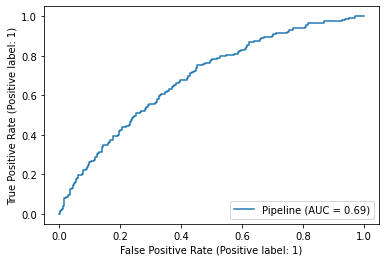

In [74]:
plot_roc_curve(pipeline, X_oot, y_oot)

In [75]:
# сохраним нашу модель
import pickle

_FILEPATH = os.path.join(os.path.dirname(os.getcwd()), 'references', 'models', 'day_3_model_response.pkl')
with open(_FILEPATH, 'wb') as pickle_file:
    pickle.dump(pipeline, pickle_file)

In [76]:
from utils.metrics import plot_metrics

In [77]:
import ipywidgets as widgets
thr_hold = widgets.FloatSlider(value=0.5,
                               min=0.0,
                               max=1.0,
                               step=0.01)

In [78]:
def plot_con(threshold):
    plot_metrics(y_oot, y_pred_prob_oot, threshold)

In [79]:
widgets.interact(plot_con,
                 threshold=thr_hold)

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

<function __main__.plot_con(threshold)>

In [80]:
from utils.metrics import get_feature_names

In [81]:
feature_names = get_feature_names(pipeline.named_steps['preprocessor'])
feature_importance = []


for i, feature in enumerate(pipeline.steps[1][1].feature_importances_):
    feature_importance.append((feature_names[i], feature))
    
    
feature_importance.sort(key=lambda x:x[1], reverse=True)
feature_importance[:10]

[('numeric__default_price_sum_60_days', 612),
 ('numeric__quantity_sum_30_days', 505),
 ('numeric__retail_disc_sum_30_days', 403),
 ('numeric__retail_disc_sum_60_days', 318),
 ('numeric__retail_disc_sum_14_days', 292),
 ('numeric__retail_disc_min_14_days', 277),
 ('numeric__retail_disc_skewness_60_days', 261),
 ('numeric__default_price_skewness_60_days', 238),
 ('numeric__retail_disc_median_14_days', 221),
 ('numeric__sales_value_std_30_days', 212)]

In [82]:
scores = y_pred_prob_oot
scores = pd.DataFrame(scores)

scores['y'] = y_oot.values
scores_sorted = scores.sort_values(1, ascending=False)[[1, 'y']]
scores_sorted['cum_recall'] = scores_sorted['y'].cumsum()
scores_sorted['position'] = range(1, scores_sorted.shape[0]+1)
scores_sorted['recall_at'] = scores_sorted['cum_recall'] / scores_sorted['y'].sum()
scores_sorted['adj_position'] = scores_sorted['position'] / scores_sorted.shape[0]+1

scores.sort_values(1, ascending=False).head(10)

0         1  y
702  0.219493  0.780507  0
134  0.224213  0.775787  1
25   0.226214  0.773786  1
7    0.228025  0.771975  0
452  0.232287  0.767713  0
773  0.235561  0.764439  1
426  0.244822  0.755178  0
723  0.245411  0.754589  0
562  0.246626  0.753374  1
470  0.247778  0.752222  0

In [83]:
scores_sorted['recall_diff'] = scores_sorted['recall_at'].diff()
scores_sorted['position_diff'] = scores_sorted['adj_position'].diff()

scores_sorted.fillna(0, inplace=True)

scores_sorted['derivative'] = scores_sorted['position_diff']  / (scores_sorted['recall_diff']+1e-6)
scores_sorted['sum_derivative'] = scores_sorted['derivative'].cumsum()

scores_sorted.sort_values(1, ascending=False).head(10)

1  y  cum_recall  position  recall_at  adj_position  recall_diff  \
702  0.780507  0           0         1   0.000000      1.001248     0.000000   
134  0.775787  1           1         2   0.006536      1.002497     0.006536   
25   0.773786  1           2         3   0.013072      1.003745     0.006536   
7    0.771975  0           2         4   0.013072      1.004994     0.000000   
452  0.767713  0           2         5   0.013072      1.006242     0.000000   
773  0.764439  1           3         6   0.019608      1.007491     0.006536   
426  0.755178  0           3         7   0.019608      1.008739     0.000000   
723  0.754589  0           3         8   0.019608      1.009988     0.000000   
562  0.753374  1           4         9   0.026144      1.011236     0.006536   
470  0.752222  0           4        10   0.026144      1.012484     0.000000   

     position_diff   derivative  sum_derivative  
702       0.000000     0.000000        0.000000  
134       0.001248     0.190982        0.190982  
25        0.001248     0.190982        0.381964  
7         0.001248  1248.439451     1248.821415  
452       0.001248  1248.439451     2497.260865  
773       0.001248     0.190982     2497.451847  
426       0.001248  1248.439451     3745.891298  
723       0.001248  1248.439451     4994.330749  
562       0.001248     0.190982     4994.521731  
470       0.001248  1248.439451     6242.961181

In [84]:
scores_sorted['recall_at'] = scores_sorted['cum_recall'] / scores_sorted['y'].sum()
scores_sorted['adj_position'] = scores_sorted['position'] / scores_sorted.shape[0]

<AxesSubplot:title={'center':'Кумулятивный recall'}, xlabel='adj_position'>

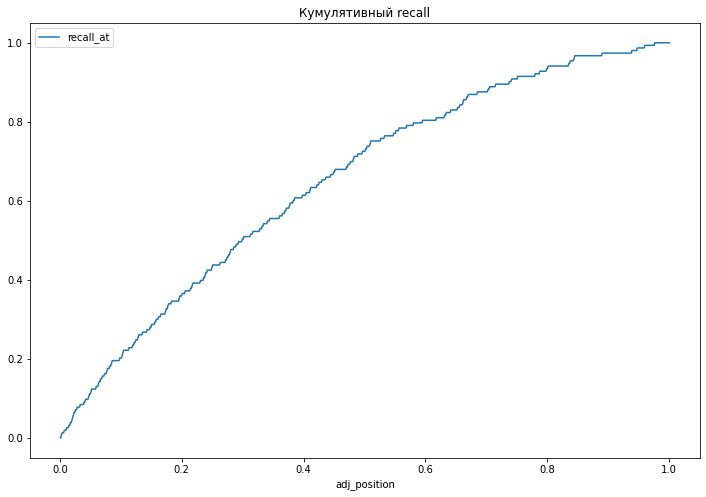

In [85]:
scores_sorted.plot(x='adj_position', y='recall_at', figsize=(12,8), title='Кумулятивный recall')

In [86]:
from utils.metrics import find_inflection_point
cutoff = find_inflection_point(scores_sorted, 5, 4, X_oot.shape[0])

In [87]:
cutoff

85

In [88]:
cutoff = cutoff / scores_sorted.shape[0]

<h4>Оценка качества модели</h4>

In [89]:
camp_mask_score = ((campaign_table_df['user_id'].isin(df['user_id'])) &\
             (campaign_table_df['campaign'] == 18))

ads_with_users_score = pd.DataFrame()
ads_with_users_score['user_id'] = campaign_table_df.loc[camp_mask_score]['user_id'].unique()
ads_with_users_score['communication'] = 1

In [90]:
due_day_score = campaign_desc_df[campaign_desc_df.campaign==18]['start_day']
due_day_2_score = campaign_desc_df[campaign_desc_df.campaign==18]['start_day'] - dt.timedelta(days=180)

prev_campaigns_score = campaign_desc_df.loc[(campaign_desc_df['start_day'] < due_day_score.values[0]) &\
                                      (campaign_desc_df['start_day'] > due_day_2_score.values[0]) &\
                                      (campaign_desc_df['campaign'] != 18)]['campaign'].values

prev_response_score = pd.DataFrame()
prev_response_score['user_id'] = coupon_red_df.loc[(coupon_red_df['campaign'].isin(prev_campaigns_score)) &\
                                           (coupon_red_df['user_id'].isin(available_users))]['user_id']
prev_response_score['prev_response'] = 1
prev_response_score.drop_duplicates(inplace=True, ignore_index=True)

In [91]:
prev_users_score_ = campaign_table_df.loc[campaign_table_df['campaign'].isin(prev_campaigns_score)]['user_id'].unique()

In [92]:
prev_users_score = pd.DataFrame()
prev_users_score['user_id'] = prev_users_score_
prev_users_score['prev_communication'] = 1

In [93]:
df = demographics_df[['user_id', 'age_desc', 'income_desc', 'no_kids']] # базовый набор характеристик

In [94]:
df = df.merge(prev_users_score, how='left', on='user_id')
df.head()

user_id age_desc income_desc  no_kids  prev_communication
0        1      65+      35-49K     True                 1.0
1        7    45-54      50-74K     True                 1.0
2        8    25-34      25-34K    False                 1.0
3       13    25-34      75-99K    False                 1.0
4       16    45-54      50-74K     True                 1.0

In [95]:
end_date_score = '2020-03-07'

In [96]:
df_score = get_feature_matrix(orders_df=orders_df,
                              date=end_date_score,
                              demogr_df=demographics_df)

In [97]:
df_score = df_score.merge(prev_users_score, how='left', on='user_id')
df_score = df_score.merge(prev_response_score, how='left', on='user_id')
df_score['prev_communication'] = df_score['prev_communication'].fillna(0).astype('int8')
df_score['prev_response'] = df_score['prev_response'].fillna(0).astype('int8')
df_score.head()

user_id age_desc income_desc  no_kids  quantity_min_14_days  \
0        1      65+      35-49K     True                  11.0   
1        7    45-54      50-74K     True                  13.0   
2        8    25-34      25-34K    False                   1.0   
3       13    25-34      75-99K    False                   2.0   
4       16    45-54      50-74K     True                   3.0   

   quantity_max_14_days  quantity_mean_14_days  quantity_median_14_days  \
0                  11.0              11.000000                     11.0   
1                  13.0              13.000000                     13.0   
2                9438.0            3156.000000                     29.0   
3               24877.0            8408.428571                     53.0   
4                   7.0               5.000000                      5.0   

   quantity_std_14_days  quantity_sum_14_days  ...  \
0                   NaN                  11.0  ...   
1                   NaN                  13.0  ...   
2           5440.389600                9468.0  ...   
3          10793.009495               58859.0  ...   
4              2.828427                  10.0  ...   

   default_price_median_60_days  default_price_std_60_days  \
0                         21.18                  48.553133   
1                         92.87                  45.756704   
2                         23.32                  44.045991   
3                         37.57                  57.909649   
4                         14.99                   6.330213   

   default_price_sum_60_days  default_price_vals_range_60_days  \
0                     397.87                            112.27   
1                     454.27                            112.93   
2                     652.16                            167.68   
3                    1350.62                            203.46   
4                      44.79                             12.66   

   default_price_quantile_25_60_days  default_price_quantile_75_60_days  \
0                               6.67                             103.89   
1                              71.06                             128.37   
2                              19.13                              47.26   
3                              21.62                              59.43   
4                              11.78                              18.11   

   default_price_interquantile_range_60_days  default_price_skewness_60_days  \
0                                      97.22                        0.765882   
1                                      57.31                       -0.633524   
2                                      28.13                        2.346431   
3                                      37.81                        1.531430   
4                                       6.33                       -0.042649   

   prev_communication  prev_response  
0                   1              1  
1                   1              0  
2                   1              1  
3                   1              1  
4                   1              0  

[5 rows x 138 columns]

In [98]:
X_score = df_score.drop(columns=['user_id'], axis=1)

In [99]:
# загрузим модель
with open(_FILEPATH, 'rb') as pickle_file:
    fitted_model = pickle.load(pickle_file)

In [100]:
scores = fitted_model.predict_proba(X_score)

In [101]:
# соберем скоры
score_df = pd.DataFrame()
score_df['customer_id'] = df_score.user_id
score_df['report_date'] = dt.date.today()
score_df['score'] = scores[:,1]

In [102]:
# наш топ клиентов, в отношении которых предполагается принять некоторые маркетинговые усилия
score_df.sort_values('score', ascending=False).iloc[:int(cutoff * score_df.shape[0]) +1, 0].values

array([ 764,  184,  418,  934, 1453, 2407,  712, 1428, 1179, 2334, 1421,
       1367, 1944, 2496,  725,   40,  696,  883,   67, 2467, 2378,  979,
        770,  170,  389,  761,  630,  113,  219,  864, 2280, 1451, 1764,
        438, 1568,  101, 1653, 1357,  218, 2351, 1529, 1197, 2360, 1864,
       2264, 2200,  306, 1475, 2479, 2217, 1142, 2070, 1337,  856, 2085,
       1907,  771, 1146, 2380,  707,  718, 2305,   22,  149,  513, 1631,
       1815,  426,  768, 2489,  624, 2007,  982, 2243, 1982,  518, 2107,
       2342, 2183, 2199, 2017, 1795, 2002, 2041, 1376,  968])

<br>
<h1>Практика 2</h1>
<h3>Построение модели отклика с углубленным целевым событием</h3>

<h4>Сбор обучающей выборки</h4>
<br>
<i>Используем уже собранную выборку, но моменяем таргет</i>

<h3>Разметка целевого события</h3>

In [103]:
feature_matrix_coupon = feature_matrix.drop('y', axis=1)

feature_matrix_coupon.head()

user_id age_desc income_desc  no_kids  quantity_min_14_days  \
0        1      65+      35-49K     True                   1.0   
1        7    45-54      50-74K     True                   NaN   
2        8    25-34      25-34K    False                   NaN   
3       13    25-34      75-99K    False                   8.0   
4       16    45-54      50-74K     True                   1.0   

   quantity_max_14_days  quantity_mean_14_days  quantity_median_14_days  \
0                  46.0                   23.5                     23.5   
1                   NaN                    NaN                      NaN   
2                   NaN                    NaN                      NaN   
3               17266.0                 9612.0                  14496.0   
4                9598.0                 1922.8                      5.0   

   quantity_std_14_days  quantity_sum_14_days  ...  \
0             31.819805                  47.0  ...   
1                   NaN                   NaN  ...   
2                   NaN                   NaN  ...   
3           8804.842191               48060.0  ...   
4           4290.567818                9614.0  ...   

   default_price_median_60_days  default_price_std_60_days  \
0                        41.525                  55.873426   
1                        91.760                  52.856793   
2                        42.260                  54.751945   
3                        46.000                  33.037212   
4                         9.570                  10.590970   

   default_price_sum_60_days  default_price_vals_range_60_days  \
0                     427.38                            120.69   
1                     361.04                            131.79   
2                     757.90                            153.15   
3                    1289.86                            121.82   
4                     217.03                             32.57   

   default_price_quantile_25_60_days  default_price_quantile_75_60_days  \
0                             1.3900                           108.5850   
1                            30.7700                            91.9400   
2                            33.2900                           109.7750   
3                            32.0400                            71.6000   
4                             5.8975                            17.2375   

   default_price_interquantile_range_60_days  default_price_skewness_60_days  \
0                                    107.195                        0.176591   
1                                     61.170                       -0.078820   
2                                     76.485                        0.793105   
3                                     39.560                        0.651746   
4                                     11.340                        1.186449   

   prev_communication  prev_response  
0                   1              0  
1                   0              0  
2                   1              0  
3                   1              1  
4                   1              0  

[5 rows x 138 columns]

In [104]:
feature_matrix_coupon['y'] = feature_matrix_oot['user_id'].apply(lambda x: is_target(x,
                                                  coupon_red_df.loc[coupon_red_df.coupon_upc == 10000085363]\
                                                  ['user_id'].unique()))

In [105]:
y = feature_matrix_coupon['y']
X = feature_matrix_coupon.drop(columns=['y', 'user_id'], axis=1)

In [106]:
y.value_counts()

0    770
1     31
Name: y, dtype: int64

<h4>Подбор оптимальных гиперпараметров и обучение модели</h4>

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25,random_state=42)

In [108]:
pipeline = create_pipeline(cat_features=categorical_features,
                           numer_features=numeric_features,
                           model=LGBMClassifier(objective = "binary", random_state = 42, is_unbalance=True))

In [109]:
best = param_search(pipeline, X_train, y_train, search_space)

100%|██████████| 100/100 [01:58<00:00,  1.18s/trial, best loss: -0.6326757733007733]


In [110]:
best_params = unpack_model_params(best)
pipeline.set_params(**best_params)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['quantity_min_14_days',
                                                   'quantity_max_14_days',
                                                   'quantity_mean_14_days',
                                                   'quantity_median_14_days',
                                                   'quantity_std_14_days',
                                                   'quantity_sum_14_days',
                                                   'quantity_vals_range_14_days',
                                                   'quantity_quantile_25_14_day...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['age_desc', 'income_desc',
                                                   'no_kids',
                                                   'prev_communication',
                                                   'prev_response'])])),
                ('classifier',
                 LGBMClassifier(is_unbalance=True,
                                learning_rate=0.10806673375308663, max_depth=7,
                                n_estimators=300, n_jobs=8, num_leaves=43,
                                objective='binary', random_state=42,
                                reg_alpha=0.17693098676722954,
                                reg_lambda=0.9353562660460271))])

In [111]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['quantity_min_14_days',
                                                   'quantity_max_14_days',
                                                   'quantity_mean_14_days',
                                                   'quantity_median_14_days',
                                                   'quantity_std_14_days',
                                                   'quantity_sum_14_days',
                                                   'quantity_vals_range_14_days',
                                                   'quantity_quantile_25_14_day...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['age_desc', 'income_desc',
                                                   'no_kids',
                                                   'prev_communication',
                                                   'prev_response'])])),
                ('classifier',
                 LGBMClassifier(is_unbalance=True,
                                learning_rate=0.10806673375308663, max_depth=7,
                                n_estimators=300, n_jobs=8, num_leaves=43,
                                objective='binary', random_state=42,
                                reg_alpha=0.17693098676722954,
                                reg_lambda=0.9353562660460271))])

In [112]:
# повысит ли скор использование оверсемплинга
from imblearn.over_sampling import SMOTENC
columns = list(X.columns)
cat_features_idx = [columns.index(feature) for feature in categorical_features]
smote_nc = SMOTENC(categorical_features=cat_features_idx, sampling_strategy=0.25, random_state=0)
X_resampled, y_resampled = smote_nc.fit_resample(X_train.fillna(0), y_train)

In [113]:
pipeline_resampled = create_pipeline(cat_features=categorical_features,
                           numer_features=numeric_features,
                           model=LGBMClassifier(objective = "binary", random_state = 42, is_unbalance=True))

In [114]:
best_resampled = param_search(pipeline_resampled, X_resampled, y_resampled, search_space)

100%|██████████| 100/100 [02:23<00:00,  1.43s/trial, best loss: -0.9864399489399489]


In [115]:
best_params_res = unpack_model_params(best_resampled)
pipeline_resampled.set_params(**best_params_res)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['quantity_min_14_days',
                                                   'quantity_max_14_days',
                                                   'quantity_mean_14_days',
                                                   'quantity_median_14_days',
                                                   'quantity_std_14_days',
                                                   'quantity_sum_14_days',
                                                   'quantity_vals_range_14_days',
                                                   'quantity_quantile_25_14_day...
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['age_desc', 'income_desc',
                                                   'no_kids',
                                                   'prev_communication',
                                                   'prev_response'])])),
                ('classifier',
                 LGBMClassifier(is_unbalance=True,
                                learning_rate=0.4340147030581985, max_depth=11,
                                n_jobs=8, num_leaves=93, objective='binary',
                                random_state=42, reg_alpha=0.11749879041424581,
                                reg_lambda=0.8600684476308402))])

In [116]:
y_pred = pipeline.predict(X_test)

In [117]:
prob_pred = pipeline.predict_proba(X_test)

In [118]:
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Accuracy: 0.9701492537313433


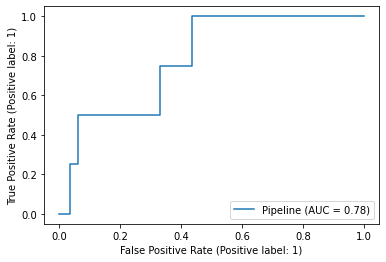

In [119]:
plot_roc_curve(pipeline, X_test, y_test)

In [120]:
pipeline_resampled.fit(X_resampled, y_resampled)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['quantity_min_14_days',
                                                   'quantity_max_14_days',
                                                   'quantity_mean_14_days',
                                                   'quantity_median_14_days',
                                                   'quantity_std_14_days',
                                                   'quantity_sum_14_days',
                                                   'quantity_vals_range_14_days',
                                                   'quantity_quantile_25_14_day...
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['age_desc', 'income_desc',
                                                   'no_kids',
                                                   'prev_communication',
                                                   'prev_response'])])),
                ('classifier',
                 LGBMClassifier(is_unbalance=True,
                                learning_rate=0.4340147030581985, max_depth=11,
                                n_jobs=8, num_leaves=93, objective='binary',
                                random_state=42, reg_alpha=0.11749879041424581,
                                reg_lambda=0.8600684476308402))])

In [121]:
y_pred_res = pipeline_resampled.predict(X_test)

In [122]:
prob_pred_res = pipeline_resampled.predict_proba(X_test)

In [123]:
print(f'Accuracy: {accuracy_score(y_test, y_pred_res)}')

Accuracy: 0.9154228855721394


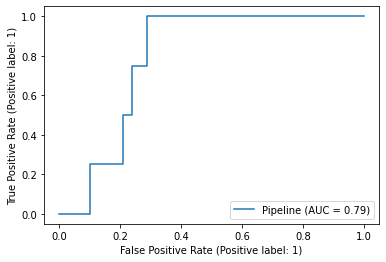

In [124]:
plot_roc_curve(pipeline_resampled, X_test, y_test)

<h4>Оценка качества модели на отложенной выборке (OOT - out of time)</h4>
<br>
<i>Новую отоженную выборку также собирать не нужно - лишь заменить таргет</i>

In [125]:
feature_matrix_coupon_oot = feature_matrix_oot.drop('y', axis=1)

feature_matrix_coupon_oot.head()

user_id age_desc income_desc  no_kids  quantity_min_14_days  \
0        1      65+      35-49K     True                   1.0   
1        7    45-54      50-74K     True                   NaN   
2        8    25-34      25-34K    False                   1.0   
3       13    25-34      75-99K    False                  32.0   
4       16    45-54      50-74K     True                   NaN   

   quantity_max_14_days  quantity_mean_14_days  quantity_median_14_days  \
0                  44.0                   16.0                      3.0   
1                   NaN                    NaN                      NaN   
2                  26.0                   13.5                     13.5   
3               25471.0                10715.0                   8678.5   
4                   NaN                    NaN                      NaN   

   quantity_std_14_days  quantity_sum_14_days  ...  \
0             24.269322                  48.0  ...   
1                   NaN                   NaN  ...   
2             17.677670                  27.0  ...   
3          12766.612576               42860.0  ...   
4                   NaN                   NaN  ...   

   default_price_median_60_days  default_price_std_60_days  \
0                        34.100                  40.060668   
1                        85.405                  99.426285   
2                        31.395                  22.456369   
3                        57.890                  46.348428   
4                           NaN                        NaN   

   default_price_sum_60_days  default_price_vals_range_60_days  \
0                     436.62                            108.89   
1                     170.81                            140.61   
2                     403.12                             65.96   
3                    1592.82                            166.48   
4                        NaN                               NaN   

   default_price_quantile_25_60_days  default_price_quantile_75_60_days  \
0                            10.0000                            80.8200   
1                            50.2525                           120.5575   
2                            26.1250                            58.8950   
3                            49.7100                           103.9625   
4                                NaN                                NaN   

   default_price_interquantile_range_60_days  default_price_skewness_60_days  \
0                                    70.8200                        0.308440   
1                                    70.3050                             NaN   
2                                    32.7700                        0.851514   
3                                    54.2525                        0.677141   
4                                        NaN                             NaN   

   prev_communication  prev_response  
0                   1              1  
1                   1              0  
2                   1              1  
3                   1              1  
4                   1              0  

[5 rows x 138 columns]

In [126]:
feature_matrix_coupon_oot['y'] = feature_matrix_oot['user_id'].apply(lambda x: is_target(x,
                                                  coupon_red_df.loc[coupon_red_df.coupon_upc == 10000085429]\
                                                  ['user_id'].unique()))

In [127]:
feature_matrix_coupon_oot.y.value_counts()

0    766
1     35
Name: y, dtype: int64

In [128]:
y_oot = feature_matrix_coupon_oot['y']
X_oot = feature_matrix_coupon_oot.drop(columns=['y', 'user_id'], axis=1)

In [129]:
y_pred_oot = pipeline.predict(X_oot)
y_pred_prob_oot = pipeline.predict_proba(X_oot)

In [130]:
print(f'Accuracy: {accuracy_score(y_oot, y_pred_oot)}')

Accuracy: 0.9525593008739076


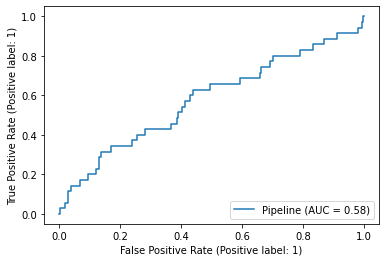

In [131]:
plot_roc_curve(pipeline, X_oot, y_oot)

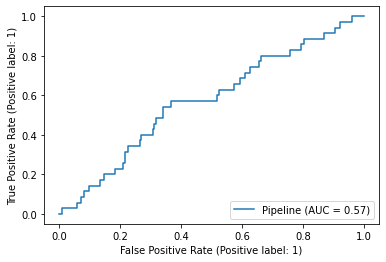

In [132]:
# оверсемплинг помог немного улучшить качество модели, так что сохраним его и используем для скоринга
plot_roc_curve(pipeline_resampled, X_oot, y_oot)

In [133]:
_FILEPATH = os.path.join(os.path.dirname(os.getcwd()), 'references', 'models', 'model_use_coupon.pkl')

with open(_FILEPATH, 'wb') as pickle_file:
    pickle.dump(pipeline, pickle_file)

In [134]:
y_pred_prob_coupon_oot = pipeline_resampled.predict_proba(X_oot)

In [135]:
scores = y_pred_prob_oot
scores = pd.DataFrame(scores)

scores['y'] = y_oot.values
scores_sorted = scores.sort_values(1, ascending=False)[[1, 'y']]
scores_sorted['cum_recall'] = scores_sorted['y'].cumsum()
scores_sorted['position'] = range(1, scores_sorted.shape[0]+1)
scores_sorted['recall_at'] = scores_sorted['cum_recall'] / scores_sorted['y'].sum()
scores_sorted['adj_position'] = scores_sorted['position'] / scores_sorted.shape[0]+1

scores.sort_values(1, ascending=False).head(10)

0         1  y
586  0.251208  0.748792  0
598  0.357902  0.642098  1
139  0.401824  0.598176  0
626  0.470045  0.529955  0
17   0.471323  0.528677  0
612  0.511842  0.488158  0
134  0.647348  0.352652  0
763  0.667588  0.332412  0
705  0.689722  0.310278  0
390  0.693803  0.306197  0

In [136]:
scores_sorted['recall_diff'] = scores_sorted['recall_at'].diff()
scores_sorted['position_diff'] = scores_sorted['adj_position'].diff()

scores_sorted.fillna(0, inplace=True)

scores_sorted['derivative'] = scores_sorted['position_diff']  / (scores_sorted['recall_diff']+1e-6)
scores_sorted['sum_derivative'] = scores_sorted['derivative'].cumsum()

scores_sorted.sort_values(1, ascending=False).head(10)

1  y  cum_recall  position  recall_at  adj_position  recall_diff  \
586  0.748792  0           0         1   0.000000      1.001248     0.000000   
598  0.642098  1           1         2   0.028571      1.002497     0.028571   
139  0.598176  0           1         3   0.028571      1.003745     0.000000   
626  0.529955  0           1         4   0.028571      1.004994     0.000000   
17   0.528677  0           1         5   0.028571      1.006242     0.000000   
612  0.488158  0           1         6   0.028571      1.007491     0.000000   
134  0.352652  0           1         7   0.028571      1.008739     0.000000   
763  0.332412  0           1         8   0.028571      1.009988     0.000000   
705  0.310278  0           1         9   0.028571      1.011236     0.000000   
390  0.306197  0           1        10   0.028571      1.012484     0.000000   

     position_diff   derivative  sum_derivative  
586       0.000000     0.000000        0.000000  
598       0.001248     0.043694        0.043694  
139       0.001248  1248.439451     1248.483145  
626       0.001248  1248.439451     2496.922595  
17        0.001248  1248.439451     3745.362046  
612       0.001248  1248.439451     4993.801497  
134       0.001248  1248.439451     6242.240947  
763       0.001248  1248.439451     7490.680398  
705       0.001248  1248.439451     8739.119849  
390       0.001248  1248.439451     9987.559299

In [137]:
scores_sorted['recall_at'] = scores_sorted['cum_recall'] / scores_sorted['y'].sum()
scores_sorted['adj_position'] = scores_sorted['position'] / scores_sorted.shape[0]

<AxesSubplot:title={'center':'Кумулятивный recall'}, xlabel='adj_position'>

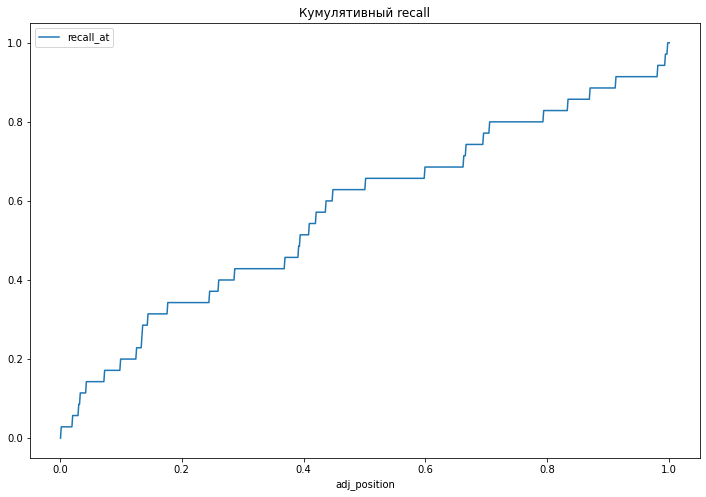

In [138]:
scores_sorted.plot(x='adj_position', y='recall_at', figsize=(12,8), title='Кумулятивный recall')

In [139]:
cutoff = find_inflection_point(scores_sorted, 5, 4, X_oot.shape[0])

In [140]:
cutoff

55

In [141]:
cutoff = cutoff / scores_sorted.shape[0]

<h4>Оценка качества модели</h4>

In [142]:
with open(_FILEPATH, 'rb') as pickle_file:
    fitted_model_coupon = pickle.load(pickle_file)

In [143]:
scores_coupon = fitted_model_coupon.predict_proba(X_score)

In [144]:
score_coupon_df = pd.DataFrame()
score_coupon_df['customer_id'] = df_score.user_id
score_coupon_df['report_date'] = dt.date.today()
score_coupon_df['score'] = scores_coupon[:,1]
score_coupon_df.sort_values('score', ascending=False).iloc[:int(cutoff * score_df.shape[0]) +1, 0].values

array([1376, 2407, 1899, 1982, 2496, 1226,  170,  768,  218,  540, 1710,
        825,  740, 1228, 2041,  438,  979, 1069,  788, 2186,  253, 2012,
       2280, 1815, 2347, 1419, 1045,   49,  982, 1633,  926, 2314,  761,
       2250, 1461, 2435, 1944,  725,  113,  856, 2115, 2017,  443,  732,
       2217, 1475, 2252, 1509,  770, 2376,  630,  426, 1391, 1024, 2322,
       2002])

<h3>Домашнее задание 1</h3>
<br>
Проведите исследование реакции пользователей для купонов в категории Grocery.<br>
Целевое событие: Погашение клиентом в рамках рекламных кампаний следующих купонов (coupon_upc)

- 8 - 10000085364
- 13 - 10000085426
- 18 - 10000085477 (можете оценить качество работы модели по результатам кампании)


<b><i>Подсказка:</i></b> Можно использовать уже подготовленные наборы данных.

<h3>Домашнее задание 2</h3>
<br>
Разметьте таргет<br>
Целевое событие: Использование клиентом купона с одним кодом (coupon_upc) не меньше двух раз в рамках РК.

- 8 - 10000085363
- 13 - 10000085429
- 18 - 10000085479 (можете оценить качество работы модели по результатам кампании)


<b><i>Подсказка:</i></b> Адаптируйте код для использования сложного таргета, предложенный в рамках предыдущих лекций.

<h3>Сложное целевое событие - Покупка в период после коммуникаций</h3>

<i>Обновим данные: теперь мы еще отследим, сколько и каких купонов активировал клиент в период рекламной кампании</i>

In [145]:
# соберем нашу базовую витрину на момент окончания рекламной кампании только на тех клиентов, с кем коммуницировали

In [146]:
camp_mask = ((campaign_table_df['user_id'].isin(available_ids)) &\
             (campaign_table_df['campaign'] == 8))

In [147]:
comm_ids = campaign_table_df.loc[camp_mask]['user_id'].unique()

In [148]:
cut_date = '2019-11-02'

In [149]:
feature_matrix_comm = get_feature_matrix(orders_df=orders_df,
                                         date=cut_date,
                                         demogr_df=demographics_df)

In [150]:
feature_matrix_comm = feature_matrix_comm[feature_matrix_comm.user_id.isin(comm_ids)]

In [151]:
# добавим информацию о коммуникации и реализации купонов в других кампаниях
due_day = campaign_desc_df[campaign_desc_df.campaign==8]['end_day']
due_day_2 = campaign_desc_df[campaign_desc_df.campaign==8]['end_day'] - dt.timedelta(days=180)

In [152]:
prev_campaigns = campaign_desc_df.loc[(campaign_desc_df['start_day'] < due_day.values[0]) &\
                                      (campaign_desc_df['start_day'] > due_day_2.values[0]) &\
                                      (campaign_desc_df['campaign'] != 8)]['campaign'].values

In [153]:
prev_response = pd.DataFrame()
prev_response['user_id'] = coupon_red_df.loc[(coupon_red_df['campaign'].isin(prev_campaigns)) &\
                                           (coupon_red_df['user_id'].isin(comm_ids))]['user_id']
prev_response['prev_response'] = 1
prev_response.drop_duplicates(inplace=True, ignore_index=True)

In [154]:
prev_users_ = campaign_table_df.loc[campaign_table_df['campaign'].isin(prev_campaigns)]['user_id'].unique()

In [155]:
prev_users = pd.DataFrame()
prev_users['user_id'] = prev_users_
prev_users['prev_communication'] = 1

In [156]:
df = demographics_df[['user_id', 'age_desc', 'income_desc', 'no_kids']] # базовый набор характеристик

In [157]:
df = df.merge(prev_users, how='left', on='user_id')
df.head()

user_id age_desc income_desc  no_kids  prev_communication
0        1      65+      35-49K     True                 1.0
1        7    45-54      50-74K     True                 1.0
2        8    25-34      25-34K    False                 1.0
3       13    25-34      75-99K    False                 1.0
4       16    45-54      50-74K     True                 1.0

In [158]:
feature_matrix_comm = feature_matrix_comm.merge(prev_users, how='left', on='user_id')
feature_matrix_comm = feature_matrix_comm.merge(prev_response, how='left', on='user_id')
feature_matrix_comm['prev_communication'] = feature_matrix_comm['prev_communication'].fillna(0).astype('int8')
feature_matrix_comm['prev_response'] = feature_matrix_comm['prev_response'].fillna(0).astype('int8')
feature_matrix_comm.head()

user_id age_desc income_desc  no_kids  quantity_min_14_days  \
0        1      65+      35-49K     True                  31.0   
1        8    25-34      25-34K    False                  10.0   
2       13    25-34      75-99K    False                  27.0   
3       16    45-54      50-74K     True                   NaN   
4       17      65+   Under 15K     True                  29.0   

   quantity_max_14_days  quantity_mean_14_days  quantity_median_14_days  \
0                  31.0                   31.0                     31.0   
1                  19.0                   14.5                     14.5   
2               18784.0                 6295.0                     74.0   
3                   NaN                    NaN                      NaN   
4                  29.0                   29.0                     29.0   

   quantity_std_14_days  quantity_sum_14_days  ...  \
0                   NaN                  31.0  ...   
1              6.363961                  29.0  ...   
2          10815.816798               18885.0  ...   
3                   NaN                   NaN  ...   
4                   NaN                  29.0  ...   

   default_price_median_60_days  default_price_std_60_days  \
0                        80.820                  54.530317   
1                        50.150                  35.994625   
2                        48.005                  48.251427   
3                        15.850                   8.796255   
4                        66.540                  34.528289   

   default_price_sum_60_days  default_price_vals_range_60_days  \
0                     635.91                            153.49   
1                     476.15                            102.81   
2                    1293.31                            183.65   
3                     188.65                             25.35   
4                     577.27                             98.92   

   default_price_quantile_25_60_days  default_price_quantile_75_60_days  \
0                            10.0000                            106.740   
1                            31.6750                             79.815   
2                            31.2075                             77.460   
3                             7.4200                             19.810   
4                            36.0500                             90.350   

   default_price_interquantile_range_60_days  default_price_skewness_60_days  \
0                                    96.7400                       -0.143832   
1                                    48.1400                        1.041205   
2                                    46.2525                        1.364696   
3                                    12.3900                        0.170284   
4                                    54.3000                        0.045571   

   prev_communication  prev_response  
0                   1              0  
1                   1              0  
2                   1              1  
3                   1              0  
4                   1              0  

[5 rows x 138 columns]

In [159]:
# теперь оценим отклик клиента в рамках последней кампании
coupons_red = coupon_red_df[(coupon_red_df.user_id.isin(comm_ids))&\
              (coupon_red_df.campaign==8)].groupby('user_id')['coupon_upc'].count().reset_index()

In [160]:
coupons_red.rename({'coupon_upc':'coupons_used'}, axis=1, inplace=True)

In [161]:
feature_matrix_comm = feature_matrix_comm.merge(coupons_red, how='left', on='user_id')
feature_matrix_comm['coupons_used'] = feature_matrix_comm['coupons_used'].fillna(0).astype('int')
feature_matrix_comm.head()

user_id age_desc income_desc  no_kids  quantity_min_14_days  \
0        1      65+      35-49K     True                  31.0   
1        8    25-34      25-34K    False                  10.0   
2       13    25-34      75-99K    False                  27.0   
3       16    45-54      50-74K     True                   NaN   
4       17      65+   Under 15K     True                  29.0   

   quantity_max_14_days  quantity_mean_14_days  quantity_median_14_days  \
0                  31.0                   31.0                     31.0   
1                  19.0                   14.5                     14.5   
2               18784.0                 6295.0                     74.0   
3                   NaN                    NaN                      NaN   
4                  29.0                   29.0                     29.0   

   quantity_std_14_days  quantity_sum_14_days  ...  default_price_std_60_days  \
0                   NaN                  31.0  ...                  54.530317   
1              6.363961                  29.0  ...                  35.994625   
2          10815.816798               18885.0  ...                  48.251427   
3                   NaN                   NaN  ...                   8.796255   
4                   NaN                  29.0  ...                  34.528289   

   default_price_sum_60_days  default_price_vals_range_60_days  \
0                     635.91                            153.49   
1                     476.15                            102.81   
2                    1293.31                            183.65   
3                     188.65                             25.35   
4                     577.27                             98.92   

   default_price_quantile_25_60_days  default_price_quantile_75_60_days  \
0                            10.0000                            106.740   
1                            31.6750                             79.815   
2                            31.2075                             77.460   
3                             7.4200                             19.810   
4                            36.0500                             90.350   

   default_price_interquantile_range_60_days  default_price_skewness_60_days  \
0                                    96.7400                       -0.143832   
1                                    48.1400                        1.041205   
2                                    46.2525                        1.364696   
3                                    12.3900                        0.170284   
4                                    54.3000                        0.045571   

   prev_communication  prev_response  coupons_used  
0                   1              0             3  
1                   1              0             1  
2                   1              1             3  
3                   1              0             0  
4                   1              0             0  

[5 rows x 139 columns]

In [162]:
# теперь оценим отклик клиента в рамках последней кампании
coupons_red_coupon = coupon_red_df[(coupon_red_df.user_id.isin(comm_ids))&\
              (coupon_red_df.coupon_upc==10000085363)].groupby('user_id')['coupon_upc'].count().reset_index()

In [163]:
coupons_red_coupon.rename({'coupon_upc':'cur_coupons_used'}, axis=1, inplace=True)

In [164]:
feature_matrix_comm = feature_matrix_comm.merge(coupons_red_coupon, how='left', on='user_id')
feature_matrix_comm['cur_coupons_used'] = feature_matrix_comm['cur_coupons_used'].fillna(0).astype('int')
feature_matrix_comm.head()

user_id age_desc income_desc  no_kids  quantity_min_14_days  \
0        1      65+      35-49K     True                  31.0   
1        8    25-34      25-34K    False                  10.0   
2       13    25-34      75-99K    False                  27.0   
3       16    45-54      50-74K     True                   NaN   
4       17      65+   Under 15K     True                  29.0   

   quantity_max_14_days  quantity_mean_14_days  quantity_median_14_days  \
0                  31.0                   31.0                     31.0   
1                  19.0                   14.5                     14.5   
2               18784.0                 6295.0                     74.0   
3                   NaN                    NaN                      NaN   
4                  29.0                   29.0                     29.0   

   quantity_std_14_days  quantity_sum_14_days  ...  default_price_sum_60_days  \
0                   NaN                  31.0  ...                     635.91   
1              6.363961                  29.0  ...                     476.15   
2          10815.816798               18885.0  ...                    1293.31   
3                   NaN                   NaN  ...                     188.65   
4                   NaN                  29.0  ...                     577.27   

   default_price_vals_range_60_days  default_price_quantile_25_60_days  \
0                            153.49                            10.0000   
1                            102.81                            31.6750   
2                            183.65                            31.2075   
3                             25.35                             7.4200   
4                             98.92                            36.0500   

   default_price_quantile_75_60_days  \
0                            106.740   
1                             79.815   
2                             77.460   
3                             19.810   
4                             90.350   

   default_price_interquantile_range_60_days  default_price_skewness_60_days  \
0                                    96.7400                       -0.143832   
1                                    48.1400                        1.041205   
2                                    46.2525                        1.364696   
3                                    12.3900                        0.170284   
4                                    54.3000                        0.045571   

   prev_communication  prev_response  coupons_used  cur_coupons_used  
0                   1              0             3                 0  
1                   1              0             1                 0  
2                   1              1             3                 0  
3                   1              0             0                 0  
4                   1              0             0                 0  

[5 rows x 140 columns]

In [165]:
#соберем таргет - клиенты должны купить товар из купона в течение двух следующих за окончанием акции недель
product_ids = coupon_df[coupon_df.coupon_upc==10000085363].product_id.values

In [166]:
start = campaign_desc_df[campaign_desc_df.campaign==8]['end_day'] + dt.timedelta(days=1)
end = campaign_desc_df[campaign_desc_df.campaign==8]['end_day'] + dt.timedelta(days=14)

In [167]:
user_comp = transactions_df[(transactions_df.purch_date_time >= start.values[0]) &\
                           (transactions_df.purch_date_time <= end.values[0]) &\
                           (transactions_df.product_id.isin(product_ids)) &\
                           (transactions_df.user_id.isin(comm_ids))].user_id.unique()

In [168]:
# наш таргет
feature_matrix_comm['y'] = feature_matrix_comm.user_id.apply(lambda x: 1 if x in user_comp else 0)
feature_matrix_comm.y.value_counts()

1    392
0    187
Name: y, dtype: int64

In [169]:
y = feature_matrix_comm['y']
X = feature_matrix_comm.drop(columns=['y', 'user_id'], axis=1)

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25,random_state=42)

In [171]:
best = param_search(pipeline, X_train, y_train, search_space)

100%|██████████| 100/100 [02:53<00:00,  1.74s/trial, best loss: -0.6844413263148994]


In [172]:
best_params = unpack_model_params(best)
pipeline.set_params(**best_params)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['quantity_min_14_days',
                                                   'quantity_max_14_days',
                                                   'quantity_mean_14_days',
                                                   'quantity_median_14_days',
                                                   'quantity_std_14_days',
                                                   'quantity_sum_14_days',
                                                   'quantity_vals_range_14_days',
                                                   'quantity_quantile_25_14_day...
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['age_desc', 'income_desc',
                                                   'no_kids',
                                                   'prev_communication',
                                                   'prev_response'])])),
                ('classifier',
                 LGBMClassifier(is_unbalance=True,
                                learning_rate=0.2591510716532963, max_depth=6,
                                n_estimators=900, n_jobs=8, num_leaves=34,
                                objective='binary', random_state=42,
                                reg_alpha=0.8043018673106045,
                                reg_lambda=0.5343937251001829))])

In [173]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['quantity_min_14_days',
                                                   'quantity_max_14_days',
                                                   'quantity_mean_14_days',
                                                   'quantity_median_14_days',
                                                   'quantity_std_14_days',
                                                   'quantity_sum_14_days',
                                                   'quantity_vals_range_14_days',
                                                   'quantity_quantile_25_14_day...
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['age_desc', 'income_desc',
                                                   'no_kids',
                                                   'prev_communication',
                                                   'prev_response'])])),
                ('classifier',
                 LGBMClassifier(is_unbalance=True,
                                learning_rate=0.2591510716532963, max_depth=6,
                                n_estimators=900, n_jobs=8, num_leaves=34,
                                objective='binary', random_state=42,
                                reg_alpha=0.8043018673106045,
                                reg_lambda=0.5343937251001829))])

In [174]:
y_pred = pipeline.predict(X_test)

In [175]:
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Accuracy: 0.6758620689655173


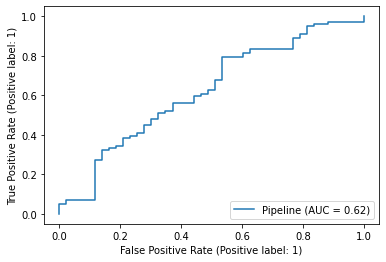

In [176]:
plot_roc_curve(pipeline, X_test, y_test)

In [177]:
camp_mask_oot = ((campaign_table_df['user_id'].isin(available_ids)) &\
             (campaign_table_df['campaign'] == 13))

In [178]:
comm_ids_oot = campaign_table_df.loc[camp_mask_oot]['user_id'].unique()

In [179]:
cut_date_oot = '2020-02-01'

In [180]:
feature_matrix_comm_oot = get_feature_matrix(orders_df=orders_df,
                                         date=cut_date_oot,
                                         demogr_df=demographics_df)

In [181]:
feature_matrix_comm_oot = feature_matrix_comm_oot[feature_matrix_comm_oot.user_id.isin(comm_ids_oot)]

In [182]:
# добавим информацию о коммуникации и реализации купонов в других кампаниях
due_day_oot = campaign_desc_df[campaign_desc_df.campaign==13]['end_day']
due_day_2_oot = campaign_desc_df[campaign_desc_df.campaign==13]['end_day'] - dt.timedelta(days=180)

In [183]:
prev_campaigns_oot = campaign_desc_df.loc[(campaign_desc_df['start_day'] < due_day_oot.values[0]) &\
                                      (campaign_desc_df['start_day'] > due_day_2_oot.values[0]) &\
                                      (campaign_desc_df['campaign'] != 13)]['campaign'].values

In [184]:
prev_response_oot = pd.DataFrame()
prev_response_oot['user_id'] = coupon_red_df.loc[(coupon_red_df['campaign'].isin(prev_campaigns_oot)) &\
                                           (coupon_red_df['user_id'].isin(comm_ids_oot))]['user_id']
prev_response_oot['prev_response'] = 1
prev_response_oot.drop_duplicates(inplace=True, ignore_index=True)

In [185]:
prev_users_oot_ = campaign_table_df.loc[campaign_table_df['campaign'].isin(prev_campaigns_oot)]['user_id'].unique()

In [186]:
prev_users_oot = pd.DataFrame()
prev_users_oot['user_id'] = prev_users_oot_
prev_users_oot['prev_communication'] = 1

In [187]:
df = demographics_df[['user_id', 'age_desc', 'income_desc', 'no_kids']] # базовый набор характеристик

In [188]:
df = df.merge(prev_users, how='left', on='user_id')
df.head()

user_id age_desc income_desc  no_kids  prev_communication
0        1      65+      35-49K     True                 1.0
1        7    45-54      50-74K     True                 1.0
2        8    25-34      25-34K    False                 1.0
3       13    25-34      75-99K    False                 1.0
4       16    45-54      50-74K     True                 1.0

In [189]:
feature_matrix_comm_oot = feature_matrix_comm_oot.merge(prev_users_oot, how='left', on='user_id')
feature_matrix_comm_oot = feature_matrix_comm_oot.merge(prev_response_oot, how='left', on='user_id')
feature_matrix_comm_oot['prev_communication'] = feature_matrix_comm_oot['prev_communication'].fillna(0).astype('int8')
feature_matrix_comm_oot['prev_response'] = feature_matrix_comm_oot['prev_response'].fillna(0).astype('int8')
feature_matrix_comm_oot.head()

user_id age_desc income_desc  no_kids  quantity_min_14_days  \
0        1      65+      35-49K     True                   1.0   
1        8    25-34      25-34K    False                  17.0   
2       13    25-34      75-99K    False                   6.0   
3       17      65+   Under 15K     True                  18.0   
4       18    45-54    100-124K     True                   0.0   

   quantity_max_14_days  quantity_mean_14_days  quantity_median_14_days  \
0                  37.0                  10.75                      2.5   
1                  25.0                  21.00                     21.0   
2               26358.0               10910.75                   8639.5   
3                  18.0                  18.00                     18.0   
4               11552.0                2322.80                     11.0   

   quantity_std_14_days  quantity_sum_14_days  ...  \
0             17.557050                  43.0  ...   
1              5.656854                  42.0  ...   
2          13111.275844               43643.0  ...   
3                   NaN                  18.0  ...   
4           5159.317561               11614.0  ...   

   default_price_median_60_days  default_price_std_60_days  \
0                          9.81                  40.273692   
1                         39.83                  46.549426   
2                         50.01                  51.711297   
3                         77.08                  13.847516   
4                         27.98                  54.963889   

   default_price_sum_60_days  default_price_vals_range_60_days  \
0                     358.48                            109.73   
1                     546.92                            167.68   
2                    1319.93                            154.75   
3                     356.20                             33.62   
4                     780.73                            186.51   

   default_price_quantile_25_60_days  default_price_quantile_75_60_days  \
0                              6.170                             42.245   
1                             19.655                             60.830   
2                             33.300                             94.745   
3                             60.350                             78.130   
4                             25.635                             56.515   

   default_price_interquantile_range_60_days  default_price_skewness_60_days  \
0                                     36.075                        1.434821   
1                                     41.175                        2.269659   
2                                     61.445                        0.845618   
3                                     17.780                       -0.365084   
4                                     30.880                        1.846600   

   prev_communication  prev_response  
0                   1              1  
1                   1              1  
2                   1              1  
3                   1              0  
4                   1              1  

[5 rows x 138 columns]

In [190]:
# теперь оценим отклик клиента в рамках последней кампании
coupons_red_oot = coupon_red_df[(coupon_red_df.user_id.isin(comm_ids_oot))&\
              (coupon_red_df.campaign==13)].groupby('user_id')['coupon_upc'].count().reset_index()

In [191]:
coupons_red_oot.rename({'coupon_upc':'coupons_used'}, axis=1, inplace=True)

In [192]:
feature_matrix_comm_oot = feature_matrix_comm_oot.merge(coupons_red_oot, how='left', on='user_id')
feature_matrix_comm_oot['coupons_used'] = feature_matrix_comm_oot['coupons_used'].fillna(0).astype('int')
feature_matrix_comm_oot.head()

user_id age_desc income_desc  no_kids  quantity_min_14_days  \
0        1      65+      35-49K     True                   1.0   
1        8    25-34      25-34K    False                  17.0   
2       13    25-34      75-99K    False                   6.0   
3       17      65+   Under 15K     True                  18.0   
4       18    45-54    100-124K     True                   0.0   

   quantity_max_14_days  quantity_mean_14_days  quantity_median_14_days  \
0                  37.0                  10.75                      2.5   
1                  25.0                  21.00                     21.0   
2               26358.0               10910.75                   8639.5   
3                  18.0                  18.00                     18.0   
4               11552.0                2322.80                     11.0   

   quantity_std_14_days  quantity_sum_14_days  ...  default_price_std_60_days  \
0             17.557050                  43.0  ...                  40.273692   
1              5.656854                  42.0  ...                  46.549426   
2          13111.275844               43643.0  ...                  51.711297   
3                   NaN                  18.0  ...                  13.847516   
4           5159.317561               11614.0  ...                  54.963889   

   default_price_sum_60_days  default_price_vals_range_60_days  \
0                     358.48                            109.73   
1                     546.92                            167.68   
2                    1319.93                            154.75   
3                     356.20                             33.62   
4                     780.73                            186.51   

   default_price_quantile_25_60_days  default_price_quantile_75_60_days  \
0                              6.170                             42.245   
1                             19.655                             60.830   
2                             33.300                             94.745   
3                             60.350                             78.130   
4                             25.635                             56.515   

   default_price_interquantile_range_60_days  default_price_skewness_60_days  \
0                                     36.075                        1.434821   
1                                     41.175                        2.269659   
2                                     61.445                        0.845618   
3                                     17.780                       -0.365084   
4                                     30.880                        1.846600   

   prev_communication  prev_response  coupons_used  
0                   1              1             0  
1                   1              1             0  
2                   1              1             4  
3                   1              0             0  
4                   1              1             3  

[5 rows x 139 columns]

In [193]:
# теперь оценим отклик клиента в рамках последней кампании
coupons_red_coupon_oot = coupon_red_df[(coupon_red_df.user_id.isin(comm_ids_oot))&\
              (coupon_red_df.coupon_upc==10000085429)].groupby('user_id')['coupon_upc'].count().reset_index()

In [194]:
coupons_red_coupon_oot.rename({'coupon_upc':'cur_coupons_used'}, axis=1, inplace=True)

In [195]:
feature_matrix_comm_oot = feature_matrix_comm_oot.merge(coupons_red_coupon_oot, how='left', on='user_id')
feature_matrix_comm_oot['cur_coupons_used'] = feature_matrix_comm_oot['cur_coupons_used'].fillna(0).astype('int')
feature_matrix_comm_oot.head()

user_id age_desc income_desc  no_kids  quantity_min_14_days  \
0        1      65+      35-49K     True                   1.0   
1        8    25-34      25-34K    False                  17.0   
2       13    25-34      75-99K    False                   6.0   
3       17      65+   Under 15K     True                  18.0   
4       18    45-54    100-124K     True                   0.0   

   quantity_max_14_days  quantity_mean_14_days  quantity_median_14_days  \
0                  37.0                  10.75                      2.5   
1                  25.0                  21.00                     21.0   
2               26358.0               10910.75                   8639.5   
3                  18.0                  18.00                     18.0   
4               11552.0                2322.80                     11.0   

   quantity_std_14_days  quantity_sum_14_days  ...  default_price_sum_60_days  \
0             17.557050                  43.0  ...                     358.48   
1              5.656854                  42.0  ...                     546.92   
2          13111.275844               43643.0  ...                    1319.93   
3                   NaN                  18.0  ...                     356.20   
4           5159.317561               11614.0  ...                     780.73   

   default_price_vals_range_60_days  default_price_quantile_25_60_days  \
0                            109.73                              6.170   
1                            167.68                             19.655   
2                            154.75                             33.300   
3                             33.62                             60.350   
4                            186.51                             25.635   

   default_price_quantile_75_60_days  \
0                             42.245   
1                             60.830   
2                             94.745   
3                             78.130   
4                             56.515   

   default_price_interquantile_range_60_days  default_price_skewness_60_days  \
0                                     36.075                        1.434821   
1                                     41.175                        2.269659   
2                                     61.445                        0.845618   
3                                     17.780                       -0.365084   
4                                     30.880                        1.846600   

   prev_communication  prev_response  coupons_used  cur_coupons_used  
0                   1              1             0                 0  
1                   1              1             0                 0  
2                   1              1             4                 0  
3                   1              0             0                 0  
4                   1              1             3                 1  

[5 rows x 140 columns]

In [196]:
#соберем таргет - клиенты должны купить товар из купона в течение двух следующих за окончанием акции недель
product_ids_oot = coupon_df[coupon_df.coupon_upc==10000085429].product_id.values

In [197]:
start_oot = campaign_desc_df[campaign_desc_df.campaign==13]['end_day'] + dt.timedelta(days=1)
end_oot = campaign_desc_df[campaign_desc_df.campaign==13]['end_day'] + dt.timedelta(days=14)

In [198]:
user_comp_oot = transactions_df[(transactions_df.purch_date_time >= start.values[0]) &\
                           (transactions_df.purch_date_time <= end.values[0]) &\
                           (transactions_df.product_id.isin(product_ids_oot)) &\
                           (transactions_df.user_id.isin(comm_ids_oot))].user_id.unique()

In [199]:
feature_matrix_comm_oot['y'] = feature_matrix_comm_oot.user_id.apply(lambda x: 1 if x in user_comp_oot else 0)
feature_matrix_comm_oot.y.value_counts()

1    429
0    181
Name: y, dtype: int64

In [200]:
y_oot = feature_matrix_comm_oot['y']
X_oot = feature_matrix_comm_oot.drop(columns=['y', 'user_id'], axis=1)

In [201]:
y_pred_oot = pipeline.predict(X_oot)

In [202]:
print(f'Accuracy: {accuracy_score(y_oot, y_pred_oot)}')

Accuracy: 0.6786885245901639


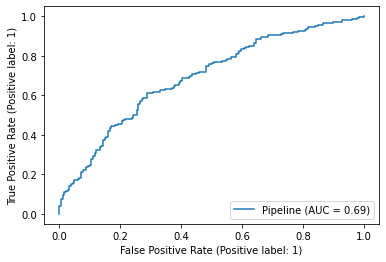

In [203]:
plot_roc_curve(pipeline, X_oot, y_oot)

In [204]:
y_pred_prob_order_oot = pipeline.predict_proba(X_oot)

In [205]:
scores_oot = y_pred_prob_order_oot
scores_oot = pd.DataFrame(scores_oot)

scores_oot['y'] = y_oot.values
scores_sorted_oot = scores_oot.sort_values(1, ascending=False)[[1, 'y']]
scores_sorted_oot['cum_recall'] = scores_sorted_oot['y'].cumsum()
scores_sorted_oot['position'] = range(1, scores_sorted_oot.shape[0]+1)
scores_sorted_oot['recall_at'] = scores_sorted_oot['cum_recall'] / scores_sorted_oot['y'].sum()
scores_sorted_oot['adj_position'] = scores_sorted_oot['position'] / scores_sorted_oot.shape[0]+1

scores_oot.sort_values(1, ascending=False).head(10)

0         1  y
58   0.001421  0.998579  1
148  0.002111  0.997889  1
322  0.002332  0.997668  1
533  0.002394  0.997606  1
551  0.002615  0.997385  1
286  0.002688  0.997312  1
396  0.002891  0.997109  1
247  0.003208  0.996792  1
147  0.003222  0.996778  1
190  0.003990  0.996010  1

In [206]:
scores_sorted_oot['recall_diff'] = scores_sorted_oot['recall_at'].diff()
scores_sorted_oot['position_diff'] = scores_sorted_oot['adj_position'].diff()

scores_sorted_oot.fillna(0, inplace=True)

scores_sorted_oot['derivative'] = scores_sorted_oot['position_diff']  / (scores_sorted_oot['recall_diff']+1e-6)
scores_sorted_oot['sum_derivative'] = scores_sorted_oot['derivative'].cumsum()

scores_sorted_oot.sort_values(1, ascending=False).head(10)

1  y  cum_recall  position  recall_at  adj_position  recall_diff  \
58   0.998579  1           1         1   0.002331      1.001639     0.000000   
148  0.997889  1           2         2   0.004662      1.003279     0.002331   
322  0.997668  1           3         3   0.006993      1.004918     0.002331   
533  0.997606  1           4         4   0.009324      1.006557     0.002331   
551  0.997385  1           5         5   0.011655      1.008197     0.002331   
286  0.997312  1           6         6   0.013986      1.009836     0.002331   
396  0.997109  1           7         7   0.016317      1.011475     0.002331   
247  0.996792  1           8         8   0.018648      1.013115     0.002331   
147  0.996778  1           9         9   0.020979      1.014754     0.002331   
190  0.996010  1          10        10   0.023310      1.016393     0.002331   

     position_diff  derivative  sum_derivative  
58        0.000000    0.000000        0.000000  
148       0.001639    0.702977        0.702977  
322       0.001639    0.702977        1.405954  
533       0.001639    0.702977        2.108931  
551       0.001639    0.702977        2.811908  
286       0.001639    0.702977        3.514886  
396       0.001639    0.702977        4.217863  
247       0.001639    0.702977        4.920840  
147       0.001639    0.702977        5.623817  
190       0.001639    0.702977        6.326794

In [207]:
scores_sorted_oot['recall_at'] = scores_sorted_oot['cum_recall'] / scores_sorted_oot['y'].sum()
scores_sorted_oot['adj_position'] = scores_sorted_oot['position'] / scores_sorted_oot.shape[0]

<AxesSubplot:title={'center':'Кумулятивный recall'}, xlabel='adj_position'>

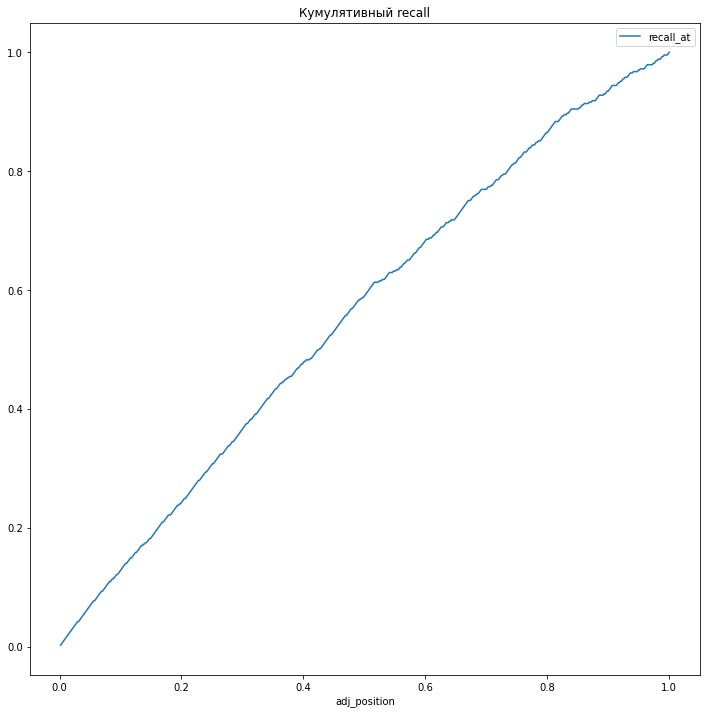

In [208]:
scores_sorted_oot.plot(x='adj_position', y='recall_at', figsize=(12,12), title='Кумулятивный recall')

In [209]:
from utils.metrics import find_inflection_point
cutoff = find_inflection_point(scores_sorted_oot, 5, 4, X_oot.shape[0])

In [210]:
cutoff

95

In [211]:
cutoff = cutoff / scores_sorted.shape[0]

<h4>Оценка качества модели</h4>

In [212]:
camp_mask_score = ((campaign_table_df['user_id'].isin(available_ids)) &\
             (campaign_table_df['campaign'] == 18))

In [213]:
comm_ids_score = campaign_table_df.loc[camp_mask_score]['user_id'].unique()

In [214]:
cut_date_score = '2020-05-02'

In [215]:
feature_matrix_comm_score = get_feature_matrix(orders_df=orders_df,
                                         date=cut_date_score,
                                         demogr_df=demographics_df)

In [216]:
feature_matrix_comm_score = feature_matrix_comm_score[feature_matrix_comm_score.user_id.isin(comm_ids_oot)]

In [217]:
# добавим информацию о коммуникации и реализации купонов в других кампаниях
due_day_score = campaign_desc_df[campaign_desc_df.campaign==18]['end_day']
due_day_2_score = campaign_desc_df[campaign_desc_df.campaign==18]['end_day'] - dt.timedelta(days=180)

In [218]:
prev_campaigns_score = campaign_desc_df.loc[(campaign_desc_df['start_day'] < due_day_score.values[0]) &\
                                      (campaign_desc_df['start_day'] > due_day_2_score.values[0]) &\
                                      (campaign_desc_df['campaign'] != 18)]['campaign'].values

In [219]:
prev_response_score = pd.DataFrame()
prev_response_score['user_id'] = coupon_red_df.loc[(coupon_red_df['campaign'].isin(prev_campaigns_score)) &\
                                           (coupon_red_df['user_id'].isin(comm_ids_score))]['user_id']
prev_response_score['prev_response'] = 1
prev_response_score.drop_duplicates(inplace=True, ignore_index=True)

In [220]:
prev_users_score_ = campaign_table_df.loc[campaign_table_df['campaign'].isin(prev_campaigns_score)]['user_id'].unique()

In [221]:
prev_users_score = pd.DataFrame()
prev_users_score['user_id'] = prev_users_score_
prev_users_score['prev_communication'] = 1

In [222]:
df = demographics_df[['user_id', 'age_desc', 'income_desc', 'no_kids']] # базовый набор характеристик

In [223]:
df = df.merge(prev_users, how='left', on='user_id')
df.head()

user_id age_desc income_desc  no_kids  prev_communication
0        1      65+      35-49K     True                 1.0
1        7    45-54      50-74K     True                 1.0
2        8    25-34      25-34K    False                 1.0
3       13    25-34      75-99K    False                 1.0
4       16    45-54      50-74K     True                 1.0

In [224]:
feature_matrix_comm_score = feature_matrix_comm_score.merge(prev_users_score, how='left', on='user_id')
feature_matrix_comm_score = feature_matrix_comm_score.merge(prev_response_score, how='left', on='user_id')
feature_matrix_comm_score['prev_communication'] = feature_matrix_comm_score['prev_communication'].fillna(0).astype('int8')
feature_matrix_comm_score['prev_response'] = feature_matrix_comm_score['prev_response'].fillna(0).astype('int8')
feature_matrix_comm_score.head()

user_id age_desc income_desc  no_kids  quantity_min_14_days  \
0        1      65+      35-49K     True                  24.0   
1        8    25-34      25-34K    False                   6.0   
2       13    25-34      75-99K    False                   1.0   
3       17      65+   Under 15K     True                  16.0   
4       18    45-54    100-124K     True                   1.0   

   quantity_max_14_days  quantity_mean_14_days  quantity_median_14_days  \
0                  39.0              31.500000                     31.5   
1                  53.0              25.250000                     21.0   
2               29383.0            8996.125000                     28.5   
3                  33.0              24.500000                     24.5   
4                  58.0              14.222222                     10.0   

   quantity_std_14_days  quantity_sum_14_days  ...  \
0             10.606602                  63.0  ...   
1             20.613507                 101.0  ...   
2          12707.608997               71969.0  ...   
3             12.020815                  49.0  ...   
4             17.661949                 128.0  ...   

   default_price_median_60_days  default_price_std_60_days  \
0                         64.98                  49.072823   
1                         37.50                  50.502548   
2                         37.22                  40.683357   
3                         77.53                  28.026056   
4                         30.44                  48.880775   

   default_price_sum_60_days  default_price_vals_range_60_days  \
0                     544.64                            155.97   
1                     754.96                            148.34   
2                    1932.26                            157.34   
3                     702.91                             82.34   
4                     956.06                            234.56   

   default_price_quantile_25_60_days  default_price_quantile_75_60_days  \
0                             28.820                             78.370   
1                             20.940                             59.850   
2                             17.860                             67.800   
3                             52.140                             88.400   
4                             19.465                             43.075   

   default_price_interquantile_range_60_days  default_price_skewness_60_days  \
0                                      49.55                        1.005391   
1                                      38.91                        1.297885   
2                                      49.94                        0.958104   
3                                      36.26                        0.528680   
4                                      23.61                        3.227768   

   prev_communication  prev_response  
0                   1              0  
1                   1              0  
2                   1              1  
3                   1              0  
4                   1              1  

[5 rows x 138 columns]

In [225]:
# теперь оценим отклик клиента в рамках последней кампании
coupons_red_score = coupon_red_df[(coupon_red_df.user_id.isin(comm_ids_score))&\
              (coupon_red_df.campaign==18)].groupby('user_id')['coupon_upc'].count().reset_index()

In [226]:
coupons_red_score.rename({'coupon_upc':'coupons_used'}, axis=1, inplace=True)

In [227]:
feature_matrix_comm_score = feature_matrix_comm_score.merge(coupons_red_score, how='left', on='user_id')
feature_matrix_comm_score['coupons_used'] = feature_matrix_comm_score['coupons_used'].fillna(0).astype('int')
feature_matrix_comm_score.head()

user_id age_desc income_desc  no_kids  quantity_min_14_days  \
0        1      65+      35-49K     True                  24.0   
1        8    25-34      25-34K    False                   6.0   
2       13    25-34      75-99K    False                   1.0   
3       17      65+   Under 15K     True                  16.0   
4       18    45-54    100-124K     True                   1.0   

   quantity_max_14_days  quantity_mean_14_days  quantity_median_14_days  \
0                  39.0              31.500000                     31.5   
1                  53.0              25.250000                     21.0   
2               29383.0            8996.125000                     28.5   
3                  33.0              24.500000                     24.5   
4                  58.0              14.222222                     10.0   

   quantity_std_14_days  quantity_sum_14_days  ...  default_price_std_60_days  \
0             10.606602                  63.0  ...                  49.072823   
1             20.613507                 101.0  ...                  50.502548   
2          12707.608997               71969.0  ...                  40.683357   
3             12.020815                  49.0  ...                  28.026056   
4             17.661949                 128.0  ...                  48.880775   

   default_price_sum_60_days  default_price_vals_range_60_days  \
0                     544.64                            155.97   
1                     754.96                            148.34   
2                    1932.26                            157.34   
3                     702.91                             82.34   
4                     956.06                            234.56   

   default_price_quantile_25_60_days  default_price_quantile_75_60_days  \
0                             28.820                             78.370   
1                             20.940                             59.850   
2                             17.860                             67.800   
3                             52.140                             88.400   
4                             19.465                             43.075   

   default_price_interquantile_range_60_days  default_price_skewness_60_days  \
0                                      49.55                        1.005391   
1                                      38.91                        1.297885   
2                                      49.94                        0.958104   
3                                      36.26                        0.528680   
4                                      23.61                        3.227768   

   prev_communication  prev_response  coupons_used  
0                   1              0             2  
1                   1              0             0  
2                   1              1             5  
3                   1              0             0  
4                   1              1             3  

[5 rows x 139 columns]

In [228]:
# теперь оценим отклик клиента в рамках последней кампании
coupons_red_coupon_score = coupon_red_df[(coupon_red_df.user_id.isin(comm_ids_score))&\
              (coupon_red_df.coupon_upc==10000085479)].groupby('user_id')['coupon_upc'].count().reset_index()

In [229]:
coupons_red_coupon_score.rename({'coupon_upc':'cur_coupons_used'}, axis=1, inplace=True)

In [230]:
feature_matrix_comm_score = feature_matrix_comm_score.merge(coupons_red_coupon_score, how='left', on='user_id')
feature_matrix_comm_score['cur_coupons_used'] = feature_matrix_comm_score['cur_coupons_used'].fillna(0).astype('int')
feature_matrix_comm_score.head()

user_id age_desc income_desc  no_kids  quantity_min_14_days  \
0        1      65+      35-49K     True                  24.0   
1        8    25-34      25-34K    False                   6.0   
2       13    25-34      75-99K    False                   1.0   
3       17      65+   Under 15K     True                  16.0   
4       18    45-54    100-124K     True                   1.0   

   quantity_max_14_days  quantity_mean_14_days  quantity_median_14_days  \
0                  39.0              31.500000                     31.5   
1                  53.0              25.250000                     21.0   
2               29383.0            8996.125000                     28.5   
3                  33.0              24.500000                     24.5   
4                  58.0              14.222222                     10.0   

   quantity_std_14_days  quantity_sum_14_days  ...  default_price_sum_60_days  \
0             10.606602                  63.0  ...                     544.64   
1             20.613507                 101.0  ...                     754.96   
2          12707.608997               71969.0  ...                    1932.26   
3             12.020815                  49.0  ...                     702.91   
4             17.661949                 128.0  ...                     956.06   

   default_price_vals_range_60_days  default_price_quantile_25_60_days  \
0                            155.97                             28.820   
1                            148.34                             20.940   
2                            157.34                             17.860   
3                             82.34                             52.140   
4                            234.56                             19.465   

   default_price_quantile_75_60_days  \
0                             78.370   
1                             59.850   
2                             67.800   
3                             88.400   
4                             43.075   

   default_price_interquantile_range_60_days  default_price_skewness_60_days  \
0                                      49.55                        1.005391   
1                                      38.91                        1.297885   
2                                      49.94                        0.958104   
3                                      36.26                        0.528680   
4                                      23.61                        3.227768   

   prev_communication  prev_response  coupons_used  cur_coupons_used  
0                   1              0             2                 0  
1                   1              0             0                 0  
2                   1              1             5                 0  
3                   1              0             0                 0  
4                   1              1             3                 0  

[5 rows x 140 columns]

In [231]:
X_score = feature_matrix_comm_score.drop('user_id', axis=1)

In [232]:
scores_coupon = pipeline.predict_proba(X_score)

In [233]:
score_coupon_df = pd.DataFrame()
score_coupon_df['customer_id'] = feature_matrix_comm_score.user_id
score_coupon_df['report_date'] = dt.date.today()
score_coupon_df['score'] = scores_coupon[:,1]
score_coupon_df.sort_values('score', ascending=False).iloc[:int(cutoff * score_df.shape[0]) +1, 0].values

array([ 332, 1803, 2305,  411, 2237,  574, 2280,  864, 2378,  434,  513,
       2374, 1568, 1370,  859,  908, 1272,  133, 1676, 1720, 1528, 1901,
        888,  113, 2364, 2317, 1762, 2148, 2341, 2421,  371,  523, 1722,
       1944, 2129,   46, 2467,  493, 2314,  725,  367, 2217,  346,  766,
        939, 1226,  856,  131,  219, 2085, 2427, 2234, 2004,  614, 1693,
        489, 1388, 1367,  428,  164,  806, 1631, 2312,  900,  387, 1829,
       1081, 2134, 1326,  800, 2006,  895,  878, 2041,  920,  575, 1015,
        955, 2058, 2269, 1378,  871, 2343, 1927,  623, 1677, 1694,  968,
        906,  624,  715,  898, 1556, 2198, 1296, 2497])

<h3>Домашнее задание 3</h3>
<br>
Проведите исследование реакции пользователей для купонов в только в категории категории Grocery.<br>
Целевое событие: Покупка клиентом не менее двух товаров (в разных чеках), на которых действовала скидка по купону (coupon_upc)

- 8 - 10000085364
- 13 - 10000085426
- 18 - 10000085477 (можете оценить качество работы модели по результатам кампании)


<b><i>Подсказка:</i></b> Удостоверьтесь, что товары относятся к категории Grocery и обязательно сорержатся в разных корзинах одного пользователя.

<br>
<h1>Практика 3</h1>
<h3>Построение модели чувствительности к коммуникации</h3>

<h3>Группировка и фильтрация</h3>

<h4>Сбор обучающей выборки</h4>

In [234]:
# выделим кампании для обучения, отложенного теста и скоринга
train_campaigns = campaign_desc_df[campaign_desc_df.start_day <= dt.datetime(2019,12,16)]['campaign'].values
oot_campaigns = campaign_desc_df[(campaign_desc_df.start_day > dt.datetime(2019,12,16))\
                                 &(campaign_desc_df.start_day <= dt.datetime(2020,3,8))]['campaign'].values
score_campaigns = campaign_desc_df[campaign_desc_df.start_day > dt.datetime(2020,3,8)]['campaign'].values
print(train_campaigns)
print(oot_campaigns)
print(score_campaigns)

[13 11 12 10  9  8  7  6  3  5  4  1  2 30 29 28 27 26]
[15 18 17 14 16]
[24 25 20 23 21 22 19]


In [235]:
# соберем обучающую выборку - информацию обо всех клиентах, для которых делались рассылки
customer_promo = campaign_table_df[campaign_table_df.campaign.isin(train_campaigns)][['user_id', 'campaign', 'description']]

In [236]:
# в качестве среза добавим информацию о начале РК
def add_cutoff(x:int,
              df:pd.DataFrame=campaign_desc_df) -> np.datetime64:
    return(campaign_desc_df[campaign_desc_df.campaign==x].start_day.values[0])

In [237]:
customer_promo['cutoff'] = customer_promo.campaign.apply(lambda x: add_cutoff(x))

In [238]:
customer_promo.head()

user_id  campaign description     cutoff
0       17        26       TypeA 2019-03-11
1       27        26       TypeA 2019-03-11
2      212        26       TypeA 2019-03-11
3      208        26       TypeA 2019-03-11
4      192        26       TypeA 2019-03-11

In [239]:
# отфильтруем тех покупателей, по которым у нас есть соцдем информация
df = pd.DataFrame()
for date in customer_promo.cutoff.unique():
    cut_date = str(date)[:10]
    print(f'collecting data for {cut_date}', end=' ')
    available_ids = customer_promo[customer_promo.cutoff==date]['user_id'].unique()
    dem_df = demographics_df[demographics_df.user_id.isin(available_ids)]
    temp_df = get_feature_matrix(orders_df=orders_df,
                                 date=cut_date,
                                 demogr_df=dem_df)
    temp_df = temp_df.merge(customer_promo[customer_promo.cutoff==date], how='left')
    df = pd.concat([df, temp_df], axis=0)
    print('->OK!')
df.head()

collecting data for 2019-03-11 ->OK!
collecting data for 2019-06-18 ->OK!
collecting data for 2019-09-15 ->OK!
collecting data for 2019-12-16 ->OK!
collecting data for 2019-04-15 ->OK!
collecting data for 2019-05-07 ->OK!
collecting data for 2019-07-11 ->OK!
collecting data for 2019-07-16 ->OK!
collecting data for 2019-08-06 ->OK!
collecting data for 2019-08-11 ->OK!
collecting data for 2019-09-01 ->OK!
collecting data for 2019-10-08 ->OK!
collecting data for 2019-11-05 ->OK!
collecting data for 2019-11-19 ->OK!
collecting data for 2019-03-24 ->OK!
collecting data for 2019-07-21 ->OK!
collecting data for 2019-08-27 ->OK!


user_id age_desc income_desc  no_kids  quantity_min_14_days  \
0       17      65+   Under 15K     True                  15.0   
1       22    45-54      75-99K     True                  14.0   
2       27    45-54      25-34K     True                   NaN   
3       39    35-44    125-149K     True                   4.0   
4       85    25-34      35-49K     True                   1.0   

   quantity_max_14_days  quantity_mean_14_days  quantity_median_14_days  \
0                4067.0            1372.333333                     35.0   
1                  33.0              23.500000                     23.5   
2                   NaN                    NaN                      NaN   
3                  47.0              25.500000                     25.5   
4                9452.0            2030.500000                      5.5   

   quantity_std_14_days  quantity_sum_14_days  ...  default_price_std_60_days  \
0           2333.671214                4117.0  ...                  26.417327   
1             13.435029                  47.0  ...                  35.323750   
2                   NaN                   NaN  ...                   3.354513   
3             30.405592                  51.0  ...                  72.762010   
4           3785.052672               24366.0  ...                  12.192420   

   default_price_sum_60_days  default_price_vals_range_60_days  \
0                     548.41                             81.35   
1                     640.99                             97.52   
2                      24.43                              8.10   
3                     453.32                            155.14   
4                     721.11                             44.81   

   default_price_quantile_25_60_days  default_price_quantile_75_60_days  \
0                            15.8750                            47.7400   
1                            58.1750                            84.1825   
2                             4.5375                             7.5750   
3                            14.4200                           140.1300   
4                            11.5250                            30.1050   

   default_price_interquantile_range_60_days  default_price_skewness_60_days  \
0                                    31.8650                        0.967411   
1                                    26.0075                        1.392236   
2                                     3.0375                        0.173209   
3                                   125.7100                       -0.376297   
4                                    18.5800                        0.595156   

   campaign  description     cutoff  
0        26        TypeA 2019-03-11  
1        26        TypeA 2019-03-11  
2        26        TypeA 2019-03-11  
3        26        TypeA 2019-03-11  
4        26        TypeA 2019-03-11  

[5 rows x 139 columns]

In [240]:
# соберем информацию о об участии в предыдущих рк
def get_prev_response(x,
                     customer_promo):
    temp_df = customer_promo[(customer_promo.campaign==x) & (customer_promo.user_id.isin(demographics_df['user_id'].values))]
    due_day = campaign_desc_df[campaign_desc_df.campaign==x]['start_day']
    due_day_2 = campaign_desc_df[campaign_desc_df.campaign==x]['start_day'] - dt.timedelta(days=180)
    
    prev_campaigns = campaign_desc_df.loc[(campaign_desc_df['start_day'] < due_day.values[0]) &\
                                      (campaign_desc_df['start_day'] > due_day_2.values[0]) &\
                                      (campaign_desc_df['campaign'] != x)]['campaign'].values
    
    prev_users_ = campaign_table_df.loc[campaign_table_df['campaign'].isin(prev_campaigns)]['user_id'].unique()
    prev_users = pd.DataFrame()
    prev_users['user_id'] = prev_users_
    prev_users['prev_communication'] = 1
    
    temp_df = temp_df.merge(prev_users, how='left', on='user_id')
    prev_response = pd.DataFrame()
    prev_response['user_id'] = coupon_red_df.loc[(coupon_red_df['campaign'].isin(prev_campaigns)) &\
                                               (coupon_red_df['user_id'].isin(temp_df.user_id))]['user_id']
    prev_response['prev_response'] = 1
    prev_response.drop_duplicates(inplace=True, ignore_index=True)
    temp_df = temp_df.merge(prev_response, how='left', on='user_id')
    temp_df['prev_communication'] = temp_df['prev_communication'].fillna(0).astype('int8')
    temp_df['prev_response'] = temp_df['prev_response'].fillna(0).astype('int8')
    
    return(temp_df)

In [241]:
prev_response_df = pd.DataFrame()
for campaign in customer_promo.campaign.unique():
    print(f'collecting data for {campaign}', end=' ')
    temp_df = get_prev_response(campaign,
                               customer_promo)
    prev_response_df = pd.concat([prev_response_df, temp_df], axis=0)
    print('->OK!')

collecting data for 26 ->OK!
collecting data for 30 ->OK!
collecting data for 8 ->OK!
collecting data for 13 ->OK!
collecting data for 28 ->OK!
collecting data for 29 ->OK!
collecting data for 1 ->OK!
collecting data for 2 ->OK!
collecting data for 4 ->OK!
collecting data for 5 ->OK!
collecting data for 7 ->OK!
collecting data for 9 ->OK!
collecting data for 10 ->OK!
collecting data for 11 ->OK!
collecting data for 12 ->OK!
collecting data for 27 ->OK!
collecting data for 3 ->OK!
collecting data for 6 ->OK!


In [242]:
prev_response_df.head()

user_id  campaign description     cutoff  prev_communication  prev_response
0       17        26       TypeA 2019-03-11                   0              0
1       27        26       TypeA 2019-03-11                   0              0
2      212        26       TypeA 2019-03-11                   0              0
3      208        26       TypeA 2019-03-11                   0              0
4      192        26       TypeA 2019-03-11                   0              0

In [243]:
df = df.merge(prev_response_df, how='left')

In [244]:
df.head()

user_id age_desc income_desc  no_kids  quantity_min_14_days  \
0       17      65+   Under 15K     True                  15.0   
1       22    45-54      75-99K     True                  14.0   
2       27    45-54      25-34K     True                   NaN   
3       39    35-44    125-149K     True                   4.0   
4       85    25-34      35-49K     True                   1.0   

   quantity_max_14_days  quantity_mean_14_days  quantity_median_14_days  \
0                4067.0            1372.333333                     35.0   
1                  33.0              23.500000                     23.5   
2                   NaN                    NaN                      NaN   
3                  47.0              25.500000                     25.5   
4                9452.0            2030.500000                      5.5   

   quantity_std_14_days  quantity_sum_14_days  ...  \
0           2333.671214                4117.0  ...   
1             13.435029                  47.0  ...   
2                   NaN                   NaN  ...   
3             30.405592                  51.0  ...   
4           3785.052672               24366.0  ...   

   default_price_vals_range_60_days  default_price_quantile_25_60_days  \
0                             81.35                            15.8750   
1                             97.52                            58.1750   
2                              8.10                             4.5375   
3                            155.14                            14.4200   
4                             44.81                            11.5250   

   default_price_quantile_75_60_days  \
0                            47.7400   
1                            84.1825   
2                             7.5750   
3                           140.1300   
4                            30.1050   

   default_price_interquantile_range_60_days  default_price_skewness_60_days  \
0                                    31.8650                        0.967411   
1                                    26.0075                        1.392236   
2                                     3.0375                        0.173209   
3                                   125.7100                       -0.376297   
4                                    18.5800                        0.595156   

   campaign  description     cutoff  prev_communication  prev_response  
0        26        TypeA 2019-03-11                   0              0  
1        26        TypeA 2019-03-11                   0              0  
2        26        TypeA 2019-03-11                   0              0  
3        26        TypeA 2019-03-11                   0              0  
4        26        TypeA 2019-03-11                   0              0  

[5 rows x 141 columns]

<h4>Разметка целевого события</h4>

In [245]:
# соберем таргет - клиент откликнулся на коммуникацию в течение двух недель
def get_target(campaign):
    temp_df = pd.DataFrame()
    due_day = campaign_desc_df[campaign_desc_df.campaign==campaign]['start_day']
    due_day_2 = campaign_desc_df[campaign_desc_df.campaign==campaign]['start_day'] + dt.timedelta(days=14)
    ddd = coupon_red_df[(coupon_red_df.campaign==campaign)\
                  &(coupon_red_df.day >= due_day.values[0])\
                  &(coupon_red_df.day <= due_day_2.values[0])]
    temp_df['user_id'] = ddd['user_id']
    temp_df['campaign'] = campaign
    temp_df['y'] = 1
    return(temp_df.drop_duplicates(ignore_index=True))

In [246]:
response_df = pd.DataFrame()
for campaign in customer_promo.campaign.unique():
    print(f'collecting data for {campaign}', end=' ')
    temp_df = get_target(campaign)
    response_df = pd.concat([response_df, temp_df], axis=0)
    print('->OK!')

collecting data for 26 ->OK!
collecting data for 30 ->OK!
collecting data for 8 ->OK!
collecting data for 13 ->OK!
collecting data for 28 ->OK!
collecting data for 29 ->OK!
collecting data for 1 ->OK!
collecting data for 2 ->OK!
collecting data for 4 ->OK!
collecting data for 5 ->OK!
collecting data for 7 ->OK!
collecting data for 9 ->OK!
collecting data for 10 ->OK!
collecting data for 11 ->OK!
collecting data for 12 ->OK!
collecting data for 27 ->OK!
collecting data for 3 ->OK!
collecting data for 6 ->OK!


In [247]:
df = df.merge(response_df, how='left')

In [248]:
df['y'] = df.y.fillna(0).astype('int8')
df.head()

user_id age_desc income_desc  no_kids  quantity_min_14_days  \
0       17      65+   Under 15K     True                  15.0   
1       22    45-54      75-99K     True                  14.0   
2       27    45-54      25-34K     True                   NaN   
3       39    35-44    125-149K     True                   4.0   
4       85    25-34      35-49K     True                   1.0   

   quantity_max_14_days  quantity_mean_14_days  quantity_median_14_days  \
0                4067.0            1372.333333                     35.0   
1                  33.0              23.500000                     23.5   
2                   NaN                    NaN                      NaN   
3                  47.0              25.500000                     25.5   
4                9452.0            2030.500000                      5.5   

   quantity_std_14_days  quantity_sum_14_days  ...  \
0           2333.671214                4117.0  ...   
1             13.435029                  47.0  ...   
2                   NaN                   NaN  ...   
3             30.405592                  51.0  ...   
4           3785.052672               24366.0  ...   

   default_price_quantile_25_60_days  default_price_quantile_75_60_days  \
0                            15.8750                            47.7400   
1                            58.1750                            84.1825   
2                             4.5375                             7.5750   
3                            14.4200                           140.1300   
4                            11.5250                            30.1050   

   default_price_interquantile_range_60_days  default_price_skewness_60_days  \
0                                    31.8650                        0.967411   
1                                    26.0075                        1.392236   
2                                     3.0375                        0.173209   
3                                   125.7100                       -0.376297   
4                                    18.5800                        0.595156   

   campaign  description     cutoff  prev_communication  prev_response  y  
0        26        TypeA 2019-03-11                   0              0  0  
1        26        TypeA 2019-03-11                   0              0  1  
2        26        TypeA 2019-03-11                   0              0  0  
3        26        TypeA 2019-03-11                   0              0  0  
4        26        TypeA 2019-03-11                   0              0  0  

[5 rows x 142 columns]

In [249]:
df.y.value_counts()

0    2158
1     227
Name: y, dtype: int64

<h3>Домашнее задание 4</h3>
<br>
Для полученной выборки разметьте таргет<br>
Целевое событие: попрбуйте изменить время отклика для разных каналов коммуникации:<br>
<br>
Для TypeA  - 7 дней<br>
Для TypeB  - 14 дней<br>
Для TypeC  - 21 день<br>
<br>
<b><i>Подсказка:</i></b> Можете модифицировать функцию get target, чтобы она меняла размер допустимого окна отлика в зависимости от типа кампании.

In [250]:
X = df.drop(['user_id', 'campaign', 'description', 'cutoff', 'y'], axis=1)
y = df.y

<h4>Подбор оптимальных гиперпараметров и обучение модели</h4>

In [251]:
from sklearn.model_selection import train_test_split

In [252]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25,random_state=42)

In [253]:
categorical_features = ['age_desc', 'income_desc', 'no_kids', 'prev_communication', 'prev_response']
numeric_features = [feature for feature in list(X.columns) if feature not in categorical_features]

In [254]:
pipeline = create_pipeline(cat_features=categorical_features,
                           numer_features=numeric_features,
                           model=LGBMClassifier(objective = "binary", random_state = 42, is_unbalance=True))

In [255]:
best = param_search(pipeline, X_train, y_train, search_space)

100%|██████████| 100/100 [11:21<00:00,  6.82s/trial, best loss: -0.6810380046891527]


In [256]:
# передадим лучшие параметры нашей модели
best_params = unpack_model_params(best)
pipeline.set_params(**best_params)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['quantity_min_14_days',
                                                   'quantity_max_14_days',
                                                   'quantity_mean_14_days',
                                                   'quantity_median_14_days',
                                                   'quantity_std_14_days',
                                                   'quantity_sum_14_days',
                                                   'quantity_vals_range_14_days',
                                                   'quantity_quantile_25_14_day...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['age_desc', 'income_desc',
                                                   'no_kids',
                                                   'prev_communication',
                                                   'prev_response'])])),
                ('classifier',
                 LGBMClassifier(is_unbalance=True,
                                learning_rate=0.0014757126328897585,
                                max_depth=9, n_estimators=150, n_jobs=8,
                                num_leaves=46, objective='binary',
                                random_state=42, reg_alpha=0.41808617779430896,
                                reg_lambda=0.6357257651485545))])

In [257]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['quantity_min_14_days',
                                                   'quantity_max_14_days',
                                                   'quantity_mean_14_days',
                                                   'quantity_median_14_days',
                                                   'quantity_std_14_days',
                                                   'quantity_sum_14_days',
                                                   'quantity_vals_range_14_days',
                                                   'quantity_quantile_25_14_day...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['age_desc', 'income_desc',
                                                   'no_kids',
                                                   'prev_communication',
                                                   'prev_response'])])),
                ('classifier',
                 LGBMClassifier(is_unbalance=True,
                                learning_rate=0.0014757126328897585,
                                max_depth=9, n_estimators=150, n_jobs=8,
                                num_leaves=46, objective='binary',
                                random_state=42, reg_alpha=0.41808617779430896,
                                reg_lambda=0.6357257651485545))])

In [258]:
y_pred = pipeline.predict(X_test)

In [259]:
prob_pred = pipeline.predict_proba(X_test)

In [260]:
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Accuracy: 0.9128978224455612


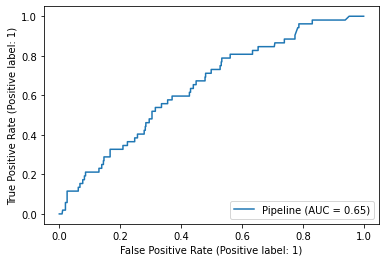

In [261]:
plot_roc_curve(pipeline, X_test, y_test)

<h4>Оценка качества модели на отложенной выборке (OOT - out of time)</h4>

In [262]:
# соберем обучающую выборку - информацию обо всех клиентах, для которых делались рассылки
customer_promo_oot = campaign_table_df[campaign_table_df.campaign.isin(oot_campaigns)][['user_id', 'campaign', 'description']]
customer_promo_oot['cutoff'] = customer_promo_oot.campaign.apply(lambda x: add_cutoff(x))

df_oot = pd.DataFrame()
for date in customer_promo_oot.cutoff.unique():
    cut_date = str(date)[:10]
    print(f'collecting data for {cut_date}', end=' ')
    available_ids = customer_promo_oot[customer_promo_oot.cutoff==date]['user_id'].unique()
    dem_df = demographics_df[demographics_df.user_id.isin(available_ids)]
    temp_df = get_feature_matrix(orders_df=orders_df,
                                 date=cut_date,
                                 demogr_df=dem_df)
    temp_df = temp_df.merge(customer_promo_oot[customer_promo_oot.cutoff==date], how='left')
    df_oot = pd.concat([df_oot, temp_df], axis=0)
    print('->OK!')
df_oot.head()

collecting data for 2020-03-08 ->OK!
collecting data for 2020-02-11 ->OK!
collecting data for 2020-02-25 ->OK!
collecting data for 2020-01-12 ->OK!
collecting data for 2020-01-28 ->OK!


user_id age_desc income_desc  no_kids  quantity_min_14_days  \
0        1      65+      35-49K     True                  11.0   
1        7    45-54      50-74K     True                  13.0   
2        8    25-34      25-34K    False                   1.0   
3       13    25-34      75-99K    False                   2.0   
4       17      65+   Under 15K     True                  32.0   

   quantity_max_14_days  quantity_mean_14_days  quantity_median_14_days  \
0                  11.0                  11.00                     11.0   
1                  13.0                  13.00                     13.0   
2                9438.0                2378.25                     37.0   
3               24877.0                7361.00                     41.0   
4                  32.0                  32.00                     32.0   

   quantity_std_14_days  quantity_sum_14_days  ...  default_price_std_60_days  \
0                   NaN                  11.0  ...                  48.553133   
1                   NaN                  13.0  ...                  45.756704   
2           4706.535129                9513.0  ...                  47.586039   
3          10422.313247               58888.0  ...                  57.546745   
4                   NaN                  32.0  ...                  50.476434   

   default_price_sum_60_days  default_price_vals_range_60_days  \
0                     397.87                            112.27   
1                     454.27                            112.93   
2                     780.84                            167.68   
3                    1459.28                            203.46   
4                     199.54                             99.28   

   default_price_quantile_25_60_days  default_price_quantile_75_60_days  \
0                              6.670                           103.8900   
1                             71.060                           128.3700   
2                             19.565                            51.1025   
3                             22.790                            64.6050   
4                             44.335                            93.9750   

   default_price_interquantile_range_60_days  default_price_skewness_60_days  \
0                                    97.2200                        0.765882   
1                                    57.3100                       -0.633524   
2                                    31.5375                        1.772117   
3                                    41.8150                        1.399441   
4                                    49.6400                       -0.900742   

   campaign  description     cutoff  
0        18        TypeA 2020-03-08  
1        18        TypeA 2020-03-08  
2        18        TypeA 2020-03-08  
3        18        TypeA 2020-03-08  
4        18        TypeA 2020-03-08  

[5 rows x 139 columns]

In [263]:
prev_response_df_oot = pd.DataFrame()
for campaign in customer_promo_oot.campaign.unique():
    print(f'collecting data for {campaign}', end=' ')
    temp_df = get_prev_response(campaign,
                               customer_promo_oot)
    prev_response_df_oot = pd.concat([prev_response_df_oot, temp_df], axis=0)
    print('->OK!')

collecting data for 18 ->OK!
collecting data for 16 ->OK!
collecting data for 17 ->OK!
collecting data for 14 ->OK!
collecting data for 15 ->OK!


In [264]:
df_oot = df_oot.merge(prev_response_df_oot, how='left')

In [265]:
response_df_oot = pd.DataFrame()
for campaign in customer_promo_oot.campaign.unique():
    print(f'collecting data for {campaign}', end=' ')
    temp_df = get_target(campaign)
    response_df_oot = pd.concat([response_df_oot, temp_df], axis=0)
    print('->OK!')

collecting data for 18 ->OK!
collecting data for 16 ->OK!
collecting data for 17 ->OK!
collecting data for 14 ->OK!
collecting data for 15 ->OK!


In [266]:
df_oot = df_oot.merge(response_df_oot, how='left')

In [267]:
df_oot['y'] = df_oot.y.fillna(0).astype('int8')
df_oot.head()

user_id age_desc income_desc  no_kids  quantity_min_14_days  \
0        1      65+      35-49K     True                  11.0   
1        7    45-54      50-74K     True                  13.0   
2        8    25-34      25-34K    False                   1.0   
3       13    25-34      75-99K    False                   2.0   
4       17      65+   Under 15K     True                  32.0   

   quantity_max_14_days  quantity_mean_14_days  quantity_median_14_days  \
0                  11.0                  11.00                     11.0   
1                  13.0                  13.00                     13.0   
2                9438.0                2378.25                     37.0   
3               24877.0                7361.00                     41.0   
4                  32.0                  32.00                     32.0   

   quantity_std_14_days  quantity_sum_14_days  ...  \
0                   NaN                  11.0  ...   
1                   NaN                  13.0  ...   
2           4706.535129                9513.0  ...   
3          10422.313247               58888.0  ...   
4                   NaN                  32.0  ...   

   default_price_quantile_25_60_days  default_price_quantile_75_60_days  \
0                              6.670                           103.8900   
1                             71.060                           128.3700   
2                             19.565                            51.1025   
3                             22.790                            64.6050   
4                             44.335                            93.9750   

   default_price_interquantile_range_60_days  default_price_skewness_60_days  \
0                                    97.2200                        0.765882   
1                                    57.3100                       -0.633524   
2                                    31.5375                        1.772117   
3                                    41.8150                        1.399441   
4                                    49.6400                       -0.900742   

   campaign  description     cutoff  prev_communication  prev_response  y  
0        18        TypeA 2020-03-08                   1              1  1  
1        18        TypeA 2020-03-08                   1              0  0  
2        18        TypeA 2020-03-08                   1              1  0  
3        18        TypeA 2020-03-08                   1              1  0  
4        18        TypeA 2020-03-08                   1              0  0  

[5 rows x 142 columns]

In [268]:
df_oot.y.value_counts()

0    931
1    109
Name: y, dtype: int64

In [269]:
X_oot = df_oot.drop(['user_id', 'campaign', 'description', 'cutoff', 'y'], axis=1)
y_oot = df_oot.y

In [270]:
y_pred_oot = pipeline.predict(X_oot)
y_pred_prob_oot = pipeline.predict_proba(X_oot)

In [271]:
print(f'Accuracy: {accuracy_score(y_oot, y_pred_oot)}')

Accuracy: 0.8951923076923077


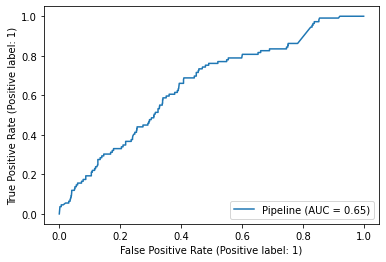

In [272]:
plot_roc_curve(pipeline, X_oot, y_oot)

In [273]:
scores = y_pred_prob_oot
scores = pd.DataFrame(scores)

scores['y'] = y_oot.values
scores_sorted = scores.sort_values(1, ascending=False)[[1, 'y']]
scores_sorted['cum_recall'] = scores_sorted['y'].cumsum()
scores_sorted['position'] = range(1, scores_sorted.shape[0]+1)
scores_sorted['recall_at'] = scores_sorted['cum_recall'] / scores_sorted['y'].sum()
scores_sorted['adj_position'] = scores_sorted['position'] / scores_sorted.shape[0]+1

scores.sort_values(1, ascending=False).head(10)

0         1  y
19   0.737706  0.262294  1
717  0.737706  0.262294  0
657  0.737706  0.262294  0
73   0.737706  0.262294  1
786  0.737706  0.262294  1
353  0.737706  0.262294  1
921  0.738219  0.261781  0
456  0.738306  0.261694  0
88   0.738306  0.261694  0
825  0.739952  0.260048  0

In [274]:
scores_sorted['recall_diff'] = scores_sorted['recall_at'].diff()
scores_sorted['position_diff'] = scores_sorted['adj_position'].diff()

scores_sorted.fillna(0, inplace=True)

scores_sorted['derivative'] = scores_sorted['position_diff']  / (scores_sorted['recall_diff']+1e-6)
scores_sorted['sum_derivative'] = scores_sorted['derivative'].cumsum()

scores_sorted.sort_values(1, ascending=False).head(10)

1  y  cum_recall  position  recall_at  adj_position  recall_diff  \
19   0.262294  1           1         1   0.009174      1.000962     0.000000   
717  0.262294  0           1         2   0.009174      1.001923     0.000000   
657  0.262294  0           1         3   0.009174      1.002885     0.000000   
73   0.262294  1           2         4   0.018349      1.003846     0.009174   
786  0.262294  1           3         5   0.027523      1.004808     0.009174   
353  0.262294  1           4         6   0.036697      1.005769     0.009174   
921  0.261781  0           4         7   0.036697      1.006731     0.000000   
456  0.261694  0           4         8   0.036697      1.007692     0.000000   
88   0.261694  0           4         9   0.036697      1.008654     0.000000   
825  0.260048  0           4        10   0.036697      1.009615     0.000000   

     position_diff  derivative  sum_derivative  
19        0.000000    0.000000        0.000000  
717       0.000962  961.538462      961.538462  
657       0.000962  961.538462     1923.076923  
73        0.000962    0.104796     1923.181719  
786       0.000962    0.104796     1923.286516  
353       0.000962    0.104796     1923.391312  
921       0.000962  961.538462     2884.929773  
456       0.000962  961.538462     3846.468235  
88        0.000962  961.538462     4808.006697  
825       0.000962  961.538462     5769.545158

In [275]:
scores_sorted['recall_at'] = scores_sorted['cum_recall'] / scores_sorted['y'].sum()
scores_sorted['adj_position'] = scores_sorted['position'] / scores_sorted.shape[0]

<AxesSubplot:title={'center':'Кумулятивный recall'}, xlabel='adj_position'>

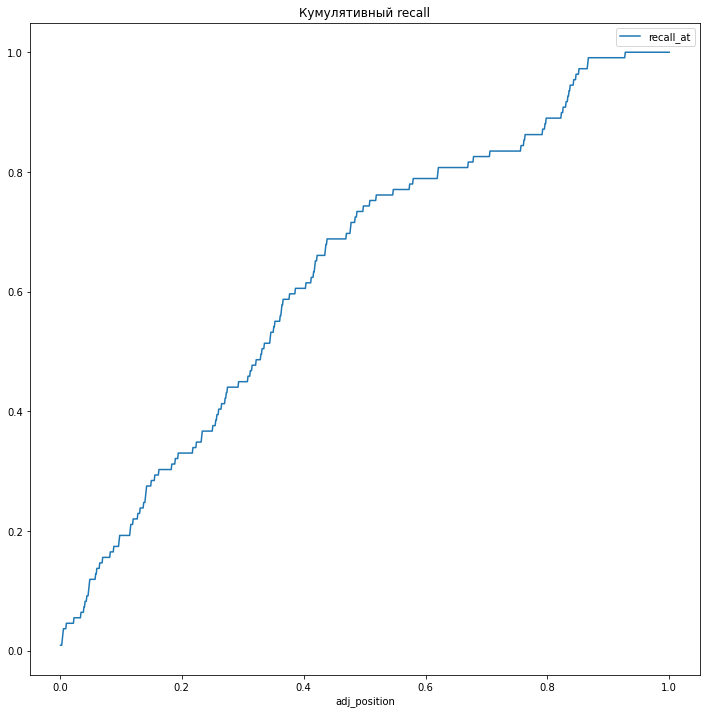

In [276]:
scores_sorted.plot(x='adj_position', y='recall_at', figsize=(12,12), title='Кумулятивный recall')

In [277]:
cutoff = find_inflection_point(scores_sorted, 5, 4, X_oot.shape[0], step=50)

In [278]:
cutoff

225

In [279]:
cutoff = cutoff / scores_sorted.shape[0]

<h4>Оценка качества модели</h4>

In [280]:
customer_promo_score = campaign_table_df[campaign_table_df.campaign.isin(score_campaigns)][['user_id', 'campaign', 'description']]
customer_promo_score['cutoff'] = customer_promo_score.campaign.apply(lambda x: add_cutoff(x))

df_score = pd.DataFrame()
for date in customer_promo_score.cutoff.unique():
    cut_date = str(date)[:10]
    print(f'collecting data for {cut_date}', end=' ')
    available_ids = customer_promo_score[customer_promo_score.cutoff==date]['user_id'].unique()
    dem_df = demographics_df[demographics_df.user_id.isin(available_ids)]
    temp_df = get_feature_matrix(orders_df=orders_df,
                                 date=cut_date,
                                 demogr_df=dem_df)
    temp_df = temp_df.merge(customer_promo_score[customer_promo_score.cutoff==date], how='left')
    df_score = pd.concat([df_score, temp_df], axis=0)
    print('->OK!')
df_score.head()

collecting data for 2020-03-24 ->OK!
collecting data for 2020-04-14 ->OK!
collecting data for 2020-05-06 ->OK!
collecting data for 2020-05-19 ->OK!
collecting data for 2020-04-05 ->OK!


user_id age_desc income_desc  no_kids  quantity_min_14_days  \
0       40    45-54   Under 15K     True                   1.0   
1       43    35-44      15-24K    False                   NaN   
2       48    19-24      35-49K     True                   NaN   
3       80    45-54      50-74K     True                  10.0   
4      110    25-34      35-49K     True                   3.0   

   quantity_max_14_days  quantity_mean_14_days  quantity_median_14_days  \
0               17930.0            3439.888889                     24.0   
1                   NaN                    NaN                      NaN   
2                   NaN                    NaN                      NaN   
3               11209.0            5609.500000                   5609.5   
4                4547.0            1808.400000                     34.0   

   quantity_std_14_days  quantity_sum_14_days  ...  default_price_std_60_days  \
0           6909.164737               30959.0  ...                  31.067902   
1                   NaN                   NaN  ...                   4.449707   
2                   NaN                   NaN  ...                   7.393575   
3           7918.888843               11219.0  ...                  38.095896   
4           2454.625796                9042.0  ...                  27.455538   

   default_price_sum_60_days  default_price_vals_range_60_days  \
0                    1568.99                            111.47   
1                      24.39                             10.77   
2                      71.85                             17.33   
3                     465.49                            109.92   
4                     612.22                            100.61   

   default_price_quantile_25_60_days  default_price_quantile_75_60_days  \
0                            11.6500                              62.98   
1                             4.0575                               7.86   
2                             7.9700                              19.22   
3                            14.7400                              76.17   
4                             7.5250                              28.66   

   default_price_interquantile_range_60_days  default_price_skewness_60_days  \
0                                    51.3300                        0.802482   
1                                     3.8025                        0.358443   
2                                    11.2500                       -0.244507   
3                                    61.4300                        0.693859   
4                                    21.1350                        2.110721   

   campaign  description     cutoff  
0        19        TypeB 2020-03-24  
1        19        TypeB 2020-03-24  
2        19        TypeB 2020-03-24  
3        19        TypeB 2020-03-24  
4        19        TypeB 2020-03-24  

[5 rows x 139 columns]

In [281]:
prev_response_df_score = pd.DataFrame()
for campaign in customer_promo_score.campaign.unique():
    print(f'collecting data for {campaign}', end=' ')
    temp_df = get_prev_response(campaign,
                               customer_promo_score)
    prev_response_df_score  = pd.concat([prev_response_df_score, temp_df], axis=0)
    print('->OK!')
    
df_score = df_score.merge(prev_response_df_score, how='left')

collecting data for 19 ->OK!
collecting data for 21 ->OK!
collecting data for 22 ->OK!
collecting data for 23 ->OK!
collecting data for 25 ->OK!
collecting data for 24 ->OK!
collecting data for 20 ->OK!


In [282]:
df_score = df_score.merge(prev_response_df_score, how='left')

In [283]:
X_score = df_score.drop(['user_id', 'campaign', 'description', 'cutoff'], axis=1)

In [284]:
scores = pipeline.predict_proba(X_score)

In [285]:
score_df = pd.DataFrame()
score_df['customer_id'] = df_score.user_id
score_df['report_date'] = dt.date.today()
score_df['score'] = scores[:,1]

In [286]:
score_df.sort_values('score', ascending=False).iloc[:int(cutoff * score_df.shape[0]) +1, 0].values

array([1937,  934, 2380,  208, 2124,  367, 2378,  283, 2004,  929, 1975,
        389, 2400,  354,  968, 2112,    1, 1677, 2280, 1633, 1726, 2280,
       2370,  825, 2234, 1944,   58,  354, 2280, 1845, 1710,  588, 1256,
       2421, 1412,  127,  256, 2085,  367,  740,  979,   58, 1509, 2134,
       2088,  895,  968, 1944,  878,  845,   22, 2467, 2467, 1337, 1529,
        256,  361,  361, 1831, 1985,  845, 2427, 2087, 2378, 2314, 1677,
       1937, 2342, 1536,  788,  647,  825, 1850,  982,   31, 2085, 1074,
       1074, 2200,   40, 2168,  283, 2427, 2199, 1428, 1261, 2374,  864,
        766, 1591, 1694,  883, 1081, 1146,  908, 1534, 1534, 1633, 1020,
       1677,  878, 1804,  771, 2455, 1804,  518, 2007, 2012,   31,  485,
       2467, 1421, 2237, 2317, 1393, 2374,   97,  351,  239, 1333, 2190,
        699, 2088, 2407, 2004,  351, 1419,  647, 2087, 1534, 1648,  997,
       1376, 2233, 1536, 2190,  771, 2088,   67, 1337, 1396,  361, 2007,
        771, 1419,  409,  718, 2364, 1815, 1917, 24

<h3>Домашнее задание 5</h3>
<br>
Соберите витрину на 19 июля 2020 года.<br>
В качестве участников используйте всех покупателей, для которых собраны анкетные данные (available ids)<br>
Сделайте так, чтобы тип кампании можно было произвольно менять (то есть, скорить датафрейм для любого типа коммуникации).
<br>
<b><i>Подсказка:</i></b> В качестве номера кампании укажите номер несуществующей РК, например 99 или 42.


<br>
<h1>Практика 4</h1>
<h3>Построение UpLift-модели</h3>

<h4>Сбор обучающей выборки</h4>

In [287]:
coupon_and_prod = coupon_df.merge(prod_df, how='left', on='product_id')
coupon_and_prod.head()

coupon_upc  product_id  campaign  manufacturer department     brand  \
0  10000089061       27160         4            69    GROCERY   Private   
1  10000089064       27754         9            69    GROCERY   Private   
2  10000089073       28897        12            69    GROCERY   Private   
3  51800009050       28919        28           236    GROCERY  National   
4  52100000076       28929        25           317    GROCERY  National   

             commodity_desc              sub_commodity_desc  \
0            SHORTENING/OIL             VEGETABLE/SALAD OIL   
1    FRZN VEGETABLE/VEG DSH  FRZN BAGGED VEGETABLES - PLAIN   
2                      EGGS                  EGGS - X-LARGE   
3  REFRGRATD DOUGH PRODUCTS       REFRIGERATED COOKIES-CHUB   
4                    CHEESE                   STRING CHEESE   

  curr_size_of_product  
0                48 OZ  
1                16 OZ  
2           A D   1 DZ  
3              16.5 OZ  
4           AB    8 OZ

In [288]:
# начнем формировать выборку для обучения
df = demographics_df[['user_id', 'age_desc', 'income_desc', 'no_kids']] # базовый набор характеристик

In [289]:
# наши уникальные айдишники:
ads_participants = campaign_table_df['user_id'].unique()
ads_participants.sort()
ads_participants.shape

(1584,)

In [290]:
camp_mask = ((campaign_table_df['user_id'].isin(df['user_id'])) &\
             (campaign_table_df['campaign'] == 13))

In [291]:
# клиенты, которым было направлено рекламное предложение хотя бы в рамках одной кампании
ads_with_users = pd.DataFrame()
ads_with_users['user_id'] = campaign_table_df.loc[camp_mask]['user_id'].unique()
ads_with_users['communication'] = 1

In [292]:
due_day_score = campaign_desc_df[campaign_desc_df.campaign==13]['start_day']
due_day_2_score = campaign_desc_df[campaign_desc_df.campaign==13]['start_day'] - dt.timedelta(days=180)

prev_campaigns_score = campaign_desc_df.loc[(campaign_desc_df['start_day'] < due_day_score.values[0]) &\
                                      (campaign_desc_df['start_day'] > due_day_2_score.values[0]) &\
                                      (campaign_desc_df['campaign'] != 13)]['campaign'].values

prev_response_score = pd.DataFrame()
prev_response_score['user_id'] = coupon_red_df.loc[(coupon_red_df['campaign'].isin(prev_campaigns_score)) &\
                                           (coupon_red_df['user_id'].isin(available_ids))]['user_id']
prev_response_score['prev_response'] = 1
prev_response_score.drop_duplicates(inplace=True, ignore_index=True)

In [293]:
prev_users_score_ = campaign_table_df.loc[campaign_table_df['campaign'].isin(prev_campaigns_score)]['user_id'].unique()

In [294]:
prev_users_score = pd.DataFrame()
prev_users_score['user_id'] = prev_users_score_
prev_users_score['prev_communication'] = 1

In [295]:
df = df.merge(prev_users_score, how='left', on='user_id')
df.head()

user_id age_desc income_desc  no_kids  prev_communication
0        1      65+      35-49K     True                 1.0
1        7    45-54      50-74K     True                 1.0
2        8    25-34      25-34K    False                 1.0
3       13    25-34      75-99K    False                 1.0
4       16    45-54      50-74K     True                 1.0

In [296]:
end_date_score = '2019-12-16'

In [297]:
df_score = get_feature_matrix(orders_df=orders_df,
                              date=end_date_score,
                              demogr_df=demographics_df)

In [298]:
df_score = df_score.merge(prev_users_score, how='left', on='user_id')
df_score = df_score.merge(prev_response_score, how='left', on='user_id')
df_score['prev_communication'] = df_score['prev_communication'].fillna(0).astype('int8')
df_score['prev_response'] = df_score['prev_response'].fillna(0).astype('int8')
df_score.head()

user_id age_desc income_desc  no_kids  quantity_min_14_days  \
0        1      65+      35-49K     True                   1.0   
1        7    45-54      50-74K     True                   NaN   
2        8    25-34      25-34K    False                  26.0   
3       13    25-34      75-99K    False                  32.0   
4       16    45-54      50-74K     True                   NaN   

   quantity_max_14_days  quantity_mean_14_days  quantity_median_14_days  \
0                  44.0                   16.0                      3.0   
1                   NaN                    NaN                      NaN   
2                  26.0                   26.0                     26.0   
3               25471.0                10715.0                   8678.5   
4                   NaN                    NaN                      NaN   

   quantity_std_14_days  quantity_sum_14_days  ...  \
0             24.269322                  48.0  ...   
1                   NaN                   NaN  ...   
2                   NaN                  26.0  ...   
3          12766.612576               42860.0  ...   
4                   NaN                   NaN  ...   

   default_price_median_60_days  default_price_std_60_days  \
0                        34.100                  40.060668   
1                        85.405                  99.426285   
2                        31.395                  22.456369   
3                        55.760                  47.486137   
4                           NaN                        NaN   

   default_price_sum_60_days  default_price_vals_range_60_days  \
0                     436.62                            108.89   
1                     170.81                            140.61   
2                     403.12                             65.96   
3                    1516.89                            166.48   
4                        NaN                               NaN   

   default_price_quantile_25_60_days  default_price_quantile_75_60_days  \
0                            10.0000                            80.8200   
1                            50.2525                           120.5575   
2                            26.1250                            58.8950   
3                            49.6100                           113.0800   
4                                NaN                                NaN   

   default_price_interquantile_range_60_days  default_price_skewness_60_days  \
0                                     70.820                        0.308440   
1                                     70.305                             NaN   
2                                     32.770                        0.851514   
3                                     63.470                        0.675983   
4                                        NaN                             NaN   

   prev_communication  prev_response  
0                   1              1  
1                   1              0  
2                   1              0  
3                   1              1  
4                   1              0  

[5 rows x 138 columns]

<h4>Разметка коммуникации и целевого события</h4>

In [299]:
# проставим флаг коммуникации
df_score = df_score.merge(ads_with_users, how='left', on='user_id')

In [300]:
df_score.rename({'communication':'W'}, axis=1, inplace=True)
df_score['W'] = df_score['W'].fillna(0).astype('int')
df_score.head()

user_id age_desc income_desc  no_kids  quantity_min_14_days  \
0        1      65+      35-49K     True                   1.0   
1        7    45-54      50-74K     True                   NaN   
2        8    25-34      25-34K    False                  26.0   
3       13    25-34      75-99K    False                  32.0   
4       16    45-54      50-74K     True                   NaN   

   quantity_max_14_days  quantity_mean_14_days  quantity_median_14_days  \
0                  44.0                   16.0                      3.0   
1                   NaN                    NaN                      NaN   
2                  26.0                   26.0                     26.0   
3               25471.0                10715.0                   8678.5   
4                   NaN                    NaN                      NaN   

   quantity_std_14_days  quantity_sum_14_days  ...  default_price_std_60_days  \
0             24.269322                  48.0  ...                  40.060668   
1                   NaN                   NaN  ...                  99.426285   
2                   NaN                  26.0  ...                  22.456369   
3          12766.612576               42860.0  ...                  47.486137   
4                   NaN                   NaN  ...                        NaN   

   default_price_sum_60_days  default_price_vals_range_60_days  \
0                     436.62                            108.89   
1                     170.81                            140.61   
2                     403.12                             65.96   
3                    1516.89                            166.48   
4                        NaN                               NaN   

   default_price_quantile_25_60_days  default_price_quantile_75_60_days  \
0                            10.0000                            80.8200   
1                            50.2525                           120.5575   
2                            26.1250                            58.8950   
3                            49.6100                           113.0800   
4                                NaN                                NaN   

   default_price_interquantile_range_60_days  default_price_skewness_60_days  \
0                                     70.820                        0.308440   
1                                     70.305                             NaN   
2                                     32.770                        0.851514   
3                                     63.470                        0.675983   
4                                        NaN                             NaN   

   prev_communication  prev_response  W  
0                   1              1  1  
1                   1              0  0  
2                   1              0  1  
3                   1              1  1  
4                   1              0  0  

[5 rows x 139 columns]

In [301]:
df_score['W'].value_counts()

1    610
0    191
Name: W, dtype: int64

In [302]:
def is_target(user_id, target_list):
    if user_id in target_list:
        return(1)
    else:
        return(0)

In [303]:
df_score['y'] = df_score['user_id'].apply(lambda x: is_target(x,
                                                  coupon_red_df.loc[coupon_red_df['campaign'] == 13]\
                                                  ['user_id'].unique()))

In [304]:
dataset, target, treatment = df_score.drop(columns=['user_id', 'W', 'y']), df_score['y'], df_score['W']

In [305]:
X_train, X_test, treat_train, treat_test, y_train, y_test = train_test_split(
    dataset, target, treatment, test_size=0.5, random_state=42)

In [306]:
categorical_features = ['age_desc', 'income_desc', 'no_kids', 'prev_communication', 'prev_response'] 

<h4>Обучение модели</h4>

In [307]:
# Базовая модель - Solo Model

In [308]:
from sklift.models import SoloModel
from catboost import CatBoostClassifier

In [309]:
# не будем строить пайплайн и доверимся встроенным инструментам catboost
model = SoloModel(CatBoostClassifier(iterations=10, thread_count=2, random_state=42, silent=False))
model.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': categorical_features})

Learning rate set to 0.47535
0:	learn: 0.4703293	total: 86.5ms	remaining: 779ms
1:	learn: 0.4027059	total: 103ms	remaining: 410ms
2:	learn: 0.3463797	total: 118ms	remaining: 275ms
3:	learn: 0.3145381	total: 134ms	remaining: 200ms
4:	learn: 0.2910572	total: 148ms	remaining: 148ms
5:	learn: 0.2669176	total: 164ms	remaining: 109ms
6:	learn: 0.2337139	total: 180ms	remaining: 76.9ms
7:	learn: 0.2212772	total: 199ms	remaining: 49.7ms
8:	learn: 0.2111545	total: 214ms	remaining: 23.8ms
9:	learn: 0.1966633	total: 229ms	remaining: 0us


SoloModel(estimator=<catboost.core.CatBoostClassifier object at 0x7f7543d80790>)

In [310]:
from sklift.metrics import uplift_at_k
uplift_predictions = model.predict(X_test)

uplift_all = uplift_at_k(y_test, uplift_predictions, treat_test, strategy='overall', k=0.3)
print(f'uplift@30%: {uplift_all:.4f}')

uplift@30%: 0.4954


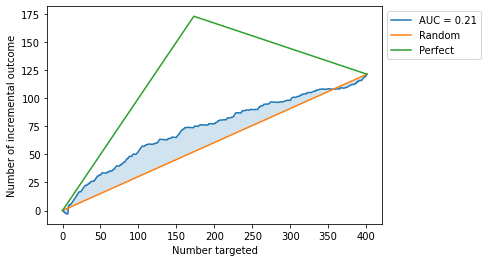

In [311]:
from sklift.viz import plot_uplift_preds, plot_uplift_curve, plot_qini_curve
plot_uplift_curve(y_test, uplift_predictions, treat_test)

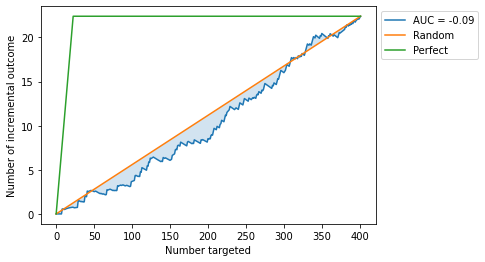

In [312]:
plot_qini_curve(y_test, uplift_predictions, treat_test, negative_effect=False)

array([<AxesSubplot:title={'center':'Treatment predictions'}, ylabel='Probability hist'>,
       <AxesSubplot:title={'center':'Control predictions'}>,
       <AxesSubplot:title={'center':'Uplift predictions'}>], dtype=object)

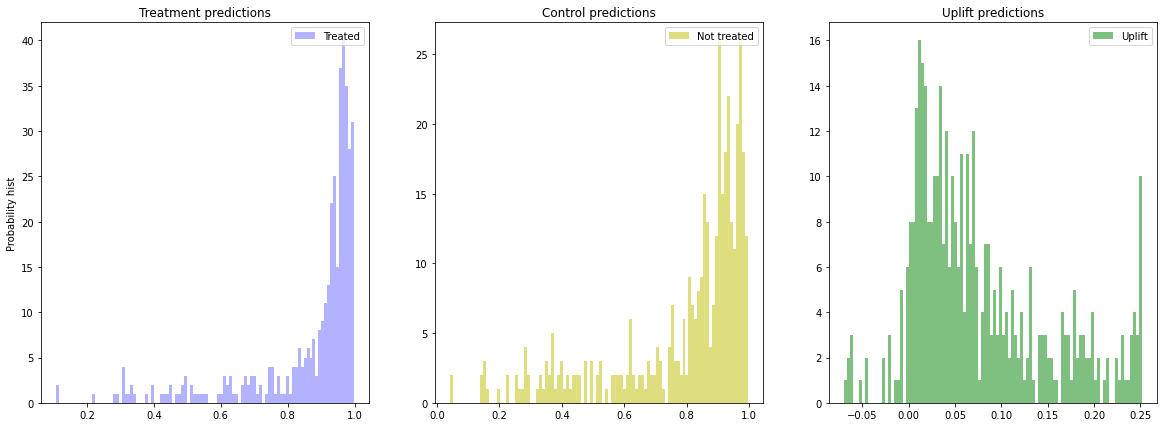

In [313]:
# вероятности при коммуникации
model_trmnt_preds = model.trmnt_preds_
# вероятности без коммуникации
model_ctrl_preds = model.ctrl_preds_

plot_uplift_preds(trmnt_preds=model_trmnt_preds, ctrl_preds=model_ctrl_preds)

<br>
<h1>Практика 5</h1>
<h3>UpLift скоринг</h3>

In [314]:
# начнем формировать выборку для обучения
df_oot = demographics_df[['user_id', 'age_desc', 'income_desc', 'no_kids']] # базовый набор характеристик

In [315]:
camp_mask_oot = ((campaign_table_df['user_id'].isin(df['user_id'])) &\
             (campaign_table_df['campaign'] == 18))

In [316]:
# клиенты, которым было направлено рекламное предложение хотя бы в рамках одной кампании
ads_with_users_oot = pd.DataFrame()
ads_with_users_oot['user_id'] = campaign_table_df.loc[camp_mask_oot]['user_id'].unique()
ads_with_users_oot['communication'] = 1

In [317]:
due_day_score_oot = campaign_desc_df[campaign_desc_df.campaign==18]['start_day']
due_day_2_score_oot = campaign_desc_df[campaign_desc_df.campaign==18]['start_day'] - dt.timedelta(days=180)

prev_campaigns_score_oot = campaign_desc_df.loc[(campaign_desc_df['start_day'] < due_day_score_oot.values[0]) &\
                                      (campaign_desc_df['start_day'] > due_day_2_score_oot.values[0]) &\
                                      (campaign_desc_df['campaign'] != 18)]['campaign'].values

prev_response_score_oot = pd.DataFrame()
prev_response_score_oot['user_id'] = coupon_red_df.loc[(coupon_red_df['campaign'].isin(prev_campaigns_score_oot)) &\
                                           (coupon_red_df['user_id'].isin(available_ids))]['user_id']
prev_response_score_oot['prev_response'] = 1
prev_response_score_oot.drop_duplicates(inplace=True, ignore_index=True)

In [318]:
prev_users_score_oot_ = campaign_table_df.loc[campaign_table_df['campaign'].isin(prev_campaigns_score_oot)]['user_id'].unique()

In [319]:
prev_users_score_oot = pd.DataFrame()
prev_users_score_oot['user_id'] = prev_users_score_oot_
prev_users_score_oot['prev_communication'] = 1

In [320]:
df_oot = df_oot.merge(prev_users_score_oot, how='left', on='user_id')
df_oot.head()

user_id age_desc income_desc  no_kids  prev_communication
0        1      65+      35-49K     True                 1.0
1        7    45-54      50-74K     True                 1.0
2        8    25-34      25-34K    False                 1.0
3       13    25-34      75-99K    False                 1.0
4       16    45-54      50-74K     True                 1.0

In [321]:
end_date_score_oot = '2020-02-01'

In [322]:
df_score_oot = get_feature_matrix(orders_df=orders_df,
                              date=end_date_score_oot,
                              demogr_df=demographics_df)

In [323]:
df_score_oot = df_score_oot.merge(prev_users_score_oot, how='left', on='user_id')
df_score_oot = df_score_oot.merge(prev_response_score_oot, how='left', on='user_id')
df_score_oot['prev_communication'] = df_score_oot['prev_communication'].fillna(0).astype('int8')
df_score_oot['prev_response'] = df_score_oot['prev_response'].fillna(0).astype('int8')
df_score_oot.head()

user_id age_desc income_desc  no_kids  quantity_min_14_days  \
0        1      65+      35-49K     True                   1.0   
1        7    45-54      50-74K     True                   NaN   
2        8    25-34      25-34K    False                  17.0   
3       13    25-34      75-99K    False                   6.0   
4       16    45-54      50-74K     True                   1.0   

   quantity_max_14_days  quantity_mean_14_days  quantity_median_14_days  \
0                  37.0                  10.75                      2.5   
1                   NaN                    NaN                      NaN   
2                  25.0                  21.00                     21.0   
3               26358.0               10910.75                   8639.5   
4                   1.0                   1.00                      1.0   

   quantity_std_14_days  quantity_sum_14_days  ...  \
0             17.557050                  43.0  ...   
1                   NaN                   NaN  ...   
2              5.656854                  42.0  ...   
3          13111.275844               43643.0  ...   
4                   NaN                   1.0  ...   

   default_price_median_60_days  default_price_std_60_days  \
0                          9.81                  40.273692   
1                         92.87                  51.361594   
2                         39.83                  46.549426   
3                         50.01                  51.711297   
4                         11.83                   4.468915   

   default_price_sum_60_days  default_price_vals_range_60_days  \
0                     358.48                            109.73   
1                     254.81                            101.80   
2                     546.92                            167.68   
3                    1319.93                            154.75   
4                      23.66                              6.32   

   default_price_quantile_25_60_days  default_price_quantile_75_60_days  \
0                              6.170                             42.245   
1                             61.470                            112.370   
2                             19.655                             60.830   
3                             33.300                             94.745   
4                             10.250                             13.410   

   default_price_interquantile_range_60_days  default_price_skewness_60_days  \
0                                     36.075                        1.434821   
1                                     50.900                       -0.678489   
2                                     41.175                        2.269659   
3                                     61.445                        0.845618   
4                                      3.160                             NaN   

   prev_communication  prev_response  
0                   1              1  
1                   1              0  
2                   1              0  
3                   1              1  
4                   1              0  

[5 rows x 138 columns]

In [324]:
# проставим флаг коммуникации
df_score_oot = df_score_oot.merge(ads_with_users_oot, how='left', on='user_id')

In [325]:
df_score_oot.rename({'communication':'W'}, axis=1, inplace=True)
df_score_oot['W'] = df_score_oot['W'].fillna(0).astype('int')
df_score_oot.head()

user_id age_desc income_desc  no_kids  quantity_min_14_days  \
0        1      65+      35-49K     True                   1.0   
1        7    45-54      50-74K     True                   NaN   
2        8    25-34      25-34K    False                  17.0   
3       13    25-34      75-99K    False                   6.0   
4       16    45-54      50-74K     True                   1.0   

   quantity_max_14_days  quantity_mean_14_days  quantity_median_14_days  \
0                  37.0                  10.75                      2.5   
1                   NaN                    NaN                      NaN   
2                  25.0                  21.00                     21.0   
3               26358.0               10910.75                   8639.5   
4                   1.0                   1.00                      1.0   

   quantity_std_14_days  quantity_sum_14_days  ...  default_price_std_60_days  \
0             17.557050                  43.0  ...                  40.273692   
1                   NaN                   NaN  ...                  51.361594   
2              5.656854                  42.0  ...                  46.549426   
3          13111.275844               43643.0  ...                  51.711297   
4                   NaN                   1.0  ...                   4.468915   

   default_price_sum_60_days  default_price_vals_range_60_days  \
0                     358.48                            109.73   
1                     254.81                            101.80   
2                     546.92                            167.68   
3                    1319.93                            154.75   
4                      23.66                              6.32   

   default_price_quantile_25_60_days  default_price_quantile_75_60_days  \
0                              6.170                             42.245   
1                             61.470                            112.370   
2                             19.655                             60.830   
3                             33.300                             94.745   
4                             10.250                             13.410   

   default_price_interquantile_range_60_days  default_price_skewness_60_days  \
0                                     36.075                        1.434821   
1                                     50.900                       -0.678489   
2                                     41.175                        2.269659   
3                                     61.445                        0.845618   
4                                      3.160                             NaN   

   prev_communication  prev_response  W  
0                   1              1  1  
1                   1              0  1  
2                   1              0  1  
3                   1              1  1  
4                   1              0  0  

[5 rows x 139 columns]

In [326]:
X_oot = df_score_oot.drop(['user_id', 'W'], axis=1)

In [327]:
uplift_predictions = model.predict(X_oot)

In [328]:
# вероятности при коммуникации
model_trmnt_preds = model.trmnt_preds_
# вероятности без коммуникации
model_ctrl_preds = model.ctrl_preds_

array([<AxesSubplot:title={'center':'Treatment predictions'}, ylabel='Probability hist'>,
       <AxesSubplot:title={'center':'Control predictions'}>,
       <AxesSubplot:title={'center':'Uplift predictions'}>], dtype=object)

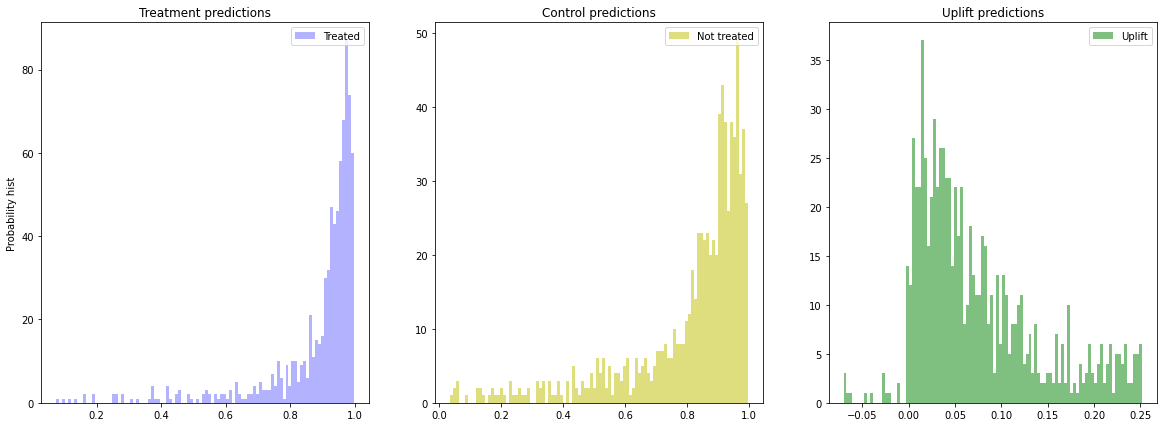

In [329]:
plot_uplift_preds(trmnt_preds=model_trmnt_preds, ctrl_preds=model_ctrl_preds)

In [330]:
oot_scores = pd.DataFrame()
oot_scores['user_id'] = df_score_oot.user_id
oot_scores['trmnt_pred'] = model_trmnt_preds
oot_scores['trmnt_bct'] = pd.qcut(oot_scores['trmnt_pred'], q=25, labels=[x for x in range(1,26)])
oot_scores['ctrl_pred'] = model_ctrl_preds
oot_scores['ctrl_bct'] = pd.qcut(oot_scores['ctrl_pred'], q=25, labels=[x for x in range(1,26)])
oot_scores['bct_shift'] = oot_scores['trmnt_bct'].astype('int8') - oot_scores['ctrl_bct'].astype('int8') 
oot_scores.sort_values('bct_shift', ascending=False).head(10)

user_id  trmnt_pred trmnt_bct  ctrl_pred ctrl_bct  bct_shift
210      621    0.932295        12   0.831045        9          3
712     2221    0.938562        13   0.845127       10          3
177      523    0.957960        16   0.890588       13          3
185      548    0.966309        18   0.911075       15          3
608     1928    0.951812        15   0.875864       12          3
391     1172    0.931795        12   0.829933        9          3
645     2030    0.939328        13   0.846868       10          3
209      614    0.932485        12   0.831469        9          3
105      306    0.956010        16   0.885885       13          3
333      986    0.930743        12   0.827601        9          3

In [331]:
oot_scores.bct_shift.value_counts().sort_index(ascending=False)

 3     13
 2    141
 1    158
 0    271
-1     98
-2     69
-3     19
-4      5
-5     12
-6      5
-7      6
-8      3
-9      1
Name: bct_shift, dtype: int64